# <p style="color:#FF0000"> Rossmann Store Sales</p>

- Qual valor das vendas de cada loja nas próximas 6 semanas?

## Coleta dos dados

Os dados foram coletados do Kaggle: https://www.kaggle.com/c/rossmann-store-sales/data

## Data fields

<b>Id</b> - id da loja

<b>Store</b> - Identificação única para a loja

<b>Sales</b> - O quanto de venda aquele produto teve diariamente

<b>Customers</b> - Número de clientes que visitaram a loja naquele dia

<b>Open</b> - Indicador se a loja está aberta ou fechada (0 = fechada, 1 = aberta)

<b>StateHoliday</b> - Indica se naquele dia está ocorrendo algum feriado do estado

<b>SchoolHoliday</b> - Indica se naquele dia está ocorrendo algum feriado escolar

<b>StoreType</b> - O tipo de loja, divididos em a,b,c e d.

<b>Assortment</b> - A disposição dos produtos em cada loja, divididos em 3 tipos, a = basic, b = extra e c = extended

<b>CompetitionDistance</b> - Distancia (em metros) para o competidor mais próximo

<b>CompetitionOpenSince[Month/Year]</b> - Mês e ano que a competição surgiu. Se eu tenho uma loja agora, daqui a 6 meses abre uma loja nova, tem a data que a competição de iniciou.

<b>Promo</b> - Indicativo se a loja está participando de uma promoção.

<b>Promo2</b> - É uma extensão da promoção. As lojas fazem promoções e outras extendem essa promoção por mais tempo. 0 = loja não participando, 1 = loja participando

<b>Promo2Since[Month/Year]</b> - Indica o tempo que a loja ficou na promoção extendida.

<b>PromoInterval</b> - Intervalo que essas promoções acontecem.

# <p style="color:#FF0000">0.0 IMPORTS</p>

In [142]:
import math
import json
import pickle
import datetime
import inflection

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as GridSpec

from scipy                 import stats as ss
from boruta                import BorutaPy
from IPython.display       import Image
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from IPython.display       import display
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## <p style="color:#FF0000">0.1 HELPER FUNCTIONS</p>

In [11]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        # start and end date for validation

        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date']  < validation_start_date ]
        validation = x_training[(x_training['date']  >= validation_start_date  ) & (x_training['date']  <= validation_end_date  )]

        #training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE_CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat)/y ))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()

    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm ) [0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( (kcorr-1) , (rcorr-1) ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [12]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['GridSpec']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## <p style="color:#FF0000">0.2 LOADING DATA</p>

In [13]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory = False) 
df_store_raw = pd.read_csv('../data/store.csv', low_memory = False) 
#Este comando low_memory fala ao read_csv para ler o arquivo todo de uma vez só.

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
#primeiro argumento: arquivo de referencia. segundo argumento: arquivo que vai ser anexado a referencia. 
#Terceiro: como fazer este merge. Quarto: igual nos dois datasets e vão servir como chave pra fazer o merge.
#merge é um método da classe pandas.

#Juntamos os dois datasetes a partir do "Store", como cada dataset tem caracteristicas da loja, juntamos tudo.

In [14]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
328098,105,3,2014-09-24,3890,573,1,0,0,0,a,c,6190.0,NaN,NaN,1,23.0,2013.0,"Mar,Jun,Sept,Dec"


# <p style="color:#FF0000">1.0 DATA DESCRIPTION</p>

## Motivação

A motivação pro trás de fazer a descrição dos dados é entender o quão desafiador será resolver problema. 

Uma primeira análise necessária é observar a quantidade de dados existentes, para assim determinar se os recursos atuais são suficientes para resolver o problema. É necessário ter uma noção do volume de dados para saber se é necessário, por exemplo, dar um upgrade nas máquinas, ou então seguir uma outra abordagem.

Outro ponto que pode tonar o projeto mais (ou menos) desafiador são os tipos de variáveis. A depender dos tipos de variáveis, as técnicas podem ser diferentes.

Além disso, precisamos analisar a quantidade de dados faltantes que existem no dataset. Dependendo da quantidade de NA nos dados existe alguns caminhos a se seguir: Ou entender o problema de negócio e assim completar os NAs de algumas forma, deletar a linha/coluna específica com os valores faltantes ou até desistir do projeto, caso se tenha muitos NAs. 

Por fim, é importante uma visão geral das estatísticas descritivas para ter uma visão mais ampla de algum problema, por exemplo, sales negativas, etc.

## Copy

In [15]:
df1 = df_raw.copy()

## <p style="color:#FF0000">1.1 Rename Columns</p>

In [16]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
#Rename

df1.columns = cols_new

In [17]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## <p style="color:#FF0000">1.2 Data Dimension</p>

In [18]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))
print(f"Total de Lojas: {len(df1['store'].unique())}")

Number of rows: 1017209
Number of cols: 18
Total de Lojas: 1115


## <p style="color:#FF0000">1.3 Data Types</p>

In [19]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

Uma primeira alteração que será necessário fazer é transformar a variável data, que está como um object, em um datetime

In [20]:
df1['date'] = pd.to_datetime(df1['date'])

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## <p style="color:#FF0000">1.4 Check NA</p>

In [22]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

É possível ver que algumas colunas contem dados faltantes e será necessário resolver este problema. É possível lidar de algumas formas com esses dados:

1. Jogar as linhas fora, o que é uma solução fácil e rápida, porém, perdermos dados.
2. Usando algoritmos de Machine Learning, existem alguns algoritmos cuja função é substituir as colunas vazias pelo comportamento dos dados não nulos da coluna.
3. Entendendo a lógica de negócio, as vezes esse NA está aí por algum motivo e precisa ser levado em consideração. Cada caso é um caso e é preciso tomar cuidado com isso. 

## <p style="color:#FF0000">1.5 Fillout NA</p>

In [23]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
457210,846,7,2014-05-18,0,0,0,0,0,0,a,c,8860.0,4.0,2004.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


### <p style="color:#FF0000">competition_distance</p>

Observando a descrição, observa-se que o campo competition_distance é a distância até o competidor mais próximo. Se houver NA, é indicativo que não há competidores próximos ou está tão longe que é considerado sem competição. Uma forma de solucionar esse problema é colocar uma distância muito maior que o máximo das distâncias, assim, é o mesmo que dizer que não há um competidor próximo.

In [24]:
df1['competition_distance'].max()

75860.0

In [25]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

Se houver um valor NA (possível observar isso olhando o math.isnan), o valor será substituído por 200000.0, o que é muito maior que nossa distância máxima. Caso contrário, retorna o valor que já se encontra na coluna.

In [26]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

É possível observar que competition_distance não tem mais valores NA.

### <p style="color:#FF0000">competition_open_since_month/year</p>

Mês e o ano em que o competidor mais próximo foi aberto. Existem duas razões para esta coluna estar vazia. A loja não tem um competidor próximo, consequentemente, não há uma data de abertura mais próxima. Outra possível explicação é que a loja tem um competidor próximo, porém não se sabe quando a loja abriu. Ou pela loja ter sido aberta muito antes da loja analisada ou alguém esqueceu de anotar. Uma solução é considerar a data de venda para esta coluna, assim, considera-se que a competição foi iniciada exatamente na data da venda.

Esta nossa solução talvez não seja a mais correta, uma vez que é possível ter competition_distance com um valor, enquanto competition_open_since_month sendo NA, isto é indicativo que alguém apenas esqueceu de anotar. Porém, para seguir no projeto, considera-se da forma indicada aqui e, caso seja possível, conversar com a equipe que organizou e montou a coluna, voltar e mudar esta regra.

In [27]:
#competition_open_since_month   
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

In [28]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### <p style="color:#FF0000">promo2_since_week/year</p>

Os campos promo2_since_week/year indicam a semana e o ano em que as lojas participaram da promo2. Lembrando que promo2 é quando a loja continua em promoção depois do prazo.

Estes dados serem NA quer dizer que a loja decidiu não participar, ou seja, não há uma data que ela começou a participar da promoção. Vamos utilizar a mesma lógica do competition_open_since_month, substituir pela data atual.

In [29]:
#promo2_since_week   
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

#promo2_since_year   
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)


In [30]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64

### <p style="color:#FF0000">promo_interval</p>

Descreve quais são os intervalos que a promo2 iniciou, nomeando os meses. Por exemplo "Feb, May, Aug, Nov", indica que as promoções ficaram ativas nesses meses.

Define-se que o que é NA será substituído por zero, uma vez que podemos considerar que não houve intervalo de promoções. Além disso, Vai ser criada uma nova feature, considerando se a loja estava em promoção ou não naquela data. Primeiro substitui-se os meses de número para escrito e criamos uma coluna nova chamada "month_map". Depois disso, compararemos se o mês da venda se encontra em promo_interval, sendo assim, é um indicativo que a loja está em promoção neste momento. Caso a loja esteja em promoção, "is_promo" = 1, caso não, 0. 

In [31]:
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [32]:
#promo_interval       
df1['promo_interval'].fillna(0, inplace = True)

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                       1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis =1)

In [33]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## <p style="color:#FF0000">1.6 Change Types</p>

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

Observamos que competition_open_since_month/year e promo2_since_week/year estão como float, porém, todos são int, uma vez que é apenas um número indicando o semana/mês/ano.

In [35]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

Caso esteja no Windows, é bem possível que os dados sejam transformados em int32, por isso é importante classificar como int64 e não apenas int.

In [36]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## <p style="color:#FF0000">1.7 Descriptive Statistical</p>

Existem duas grandes métricas na estatística, as métricas de tendência e a média de dispersão. As médias de tendência são usadas para representar todos os números de uma lista, enquanto as de dispersão são aplicadas para determinar o grau de variação dos números de uma lista com relação à sua média.

Observando a estatística é possível já ter uma noção se há algum erro, como vendas negativas, entre outras. 

É preciso separar entre atributos numéricos e categóricos, cada um tem seu próprio tipo de análise, aqui vamos iniciar com os atributos numéricos.

In [37]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### <p style="color:#FF0000">1.7.1 Numerical Atributes</p>

In [38]:
## Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat((d2,d3,d4,ct1,ct2,d1,d5,d6)).T.reset_index()
m.columns = [ 'attributes','min','max','range','mean','median','std','skew','kurtosis' ]

In [39]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Agora é preciso analisar cada uma das métricas.

Min e Max dão o menor e o maior valor.

Range é o intervalo (max - min).

Mean é a média.

Median a mediana, que separa a metade maior e a metade menor de uma amostra.

Std é o desvio padrão, que indica o quanto um conjunto de dados é uniforme.

Skew é o grau de assimetria que temos no nosso problema, podemos interpetrá-la como: Quanto maior o seu valor, mais distante da normal estamos. Se a skew for positiva, significa que a assimetria é para a direita, enquanto se for negativa, para a esquerda. 

Curtose é o grau de achatamento ou afilamento da curva em relação a sua normal. Quanto menor o valor, mas "apertada" a curva. E quanto maior o valor, mais "esticada" a curva. 

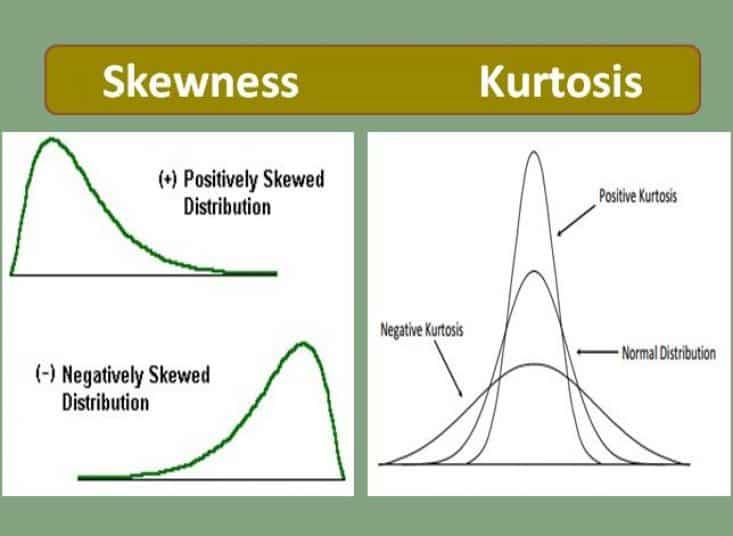

In [40]:
Image('../img/skewness-kurtosis_1JPG-.jpg')

Observando vendas, temos 0 (quando a loja possivelmente estava fechada) e máximo de 41551.0. A media e mediana são muito proximas, o que é indício de não ter um deslocamento grande da normal, o que pode ser confirmado pela skew, que é muito próxima a zero. 

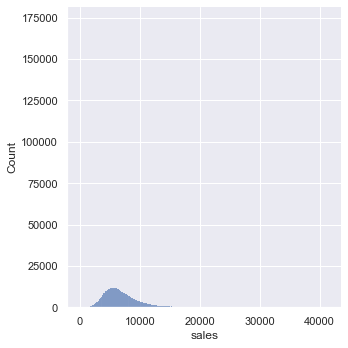

In [41]:
sns.displot(df1['sales'])

É possível ver que uma normal levemente deslocada para a esquerda, o que já era indicado pela skew positiva.

Outro exemplo que possível de se analisar é a competition_distance, a skew está próxima de 10, o que é um indício de um grande deslocamento para a esquerda, enquanto a kurtosis está em 147, o que dá a ideia de um pico muito alto. É possível então concluir que existe uma concentração muito alta de valores no início, ou seja, a maioria das competições ocorrem em distâncias pequenas, o que faz sentido, já que se a distância for muito alta não há competição. 

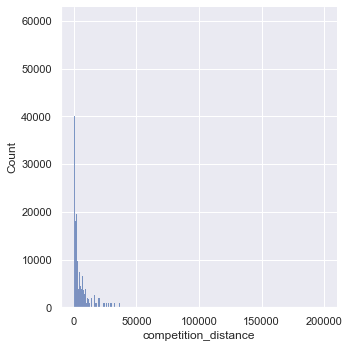

In [42]:
sns.displot(df1['competition_distance'])

### <p style="color:#FF0000">1.7.2 Categorical Atributes</p>

In [43]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Cada atributo categórico tem estes valores únicos, o que dá uma ideia do problema que será enfrentado.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

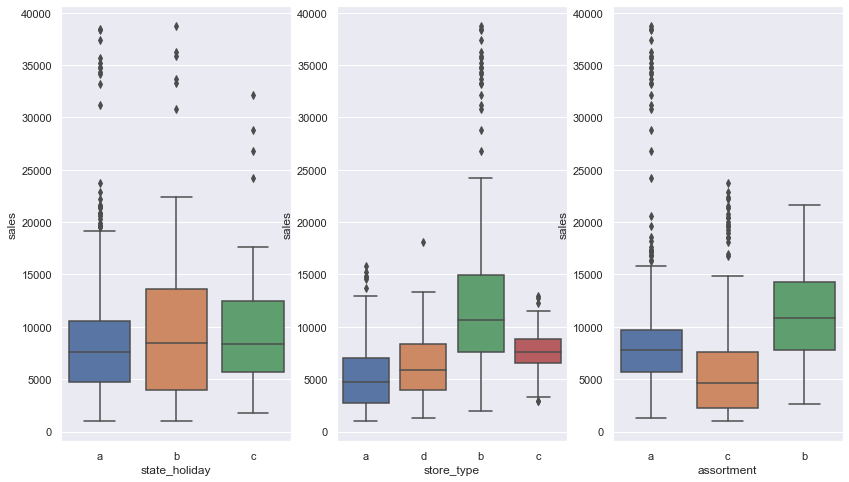

In [44]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.figure(figsize=(14, 8))
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y='sales', data=aux1)

Aqui têm-se vendas por state_holiday, store_type e assortment. O boxplot resume todas as análises em um gráfico só. O traço dentro do quadrado colorido corresponde a mediana, onde divide os dados em 50%. Deste traço até a parte superior do quadrado, são os 75% dos valores. Subindo um pouco mais, até o traço superior acima, temos o "Máximo", desconsiderando outliers, que são dados que destoam muito do padrão encontrado. A mesma análise pode ser feita para baixo.

Uma análise possível é comparar as medianas, por exemplo. Nos feriados do estado, o feriado b tem uma mediana maior que a, mas muito próxima de c. Porém, em b as vendas tão mais bem distribuídas, enquanto em c a maior parte das vendas se encontra entre os 50% e os 75%. 

Em store_type fica ainda mais visível as diferenças. A loja do tipo b tem uma mediana muito maior e também uma quantidade muito maior de outliers. Depois em c, porém os dados tão mais concentrados em torno da mediana. Em a e d as medianas são próximas, mas diferentes.

Em assortment, os produtos são muito mais distribuidos em b do que em a.

# <p style="color:#FF0000">2.0 Feature Engineering</p>

Vamos derivar features a partir do conjunto original dos nossos dados.

Precisamos ter as variáveis disponíveis para estudo durante a análise exploratória de dados.

In [45]:
df2 = df1.copy()

## <p style="color:#FF0000">2.1 Mapa mental de hipóteses</p>

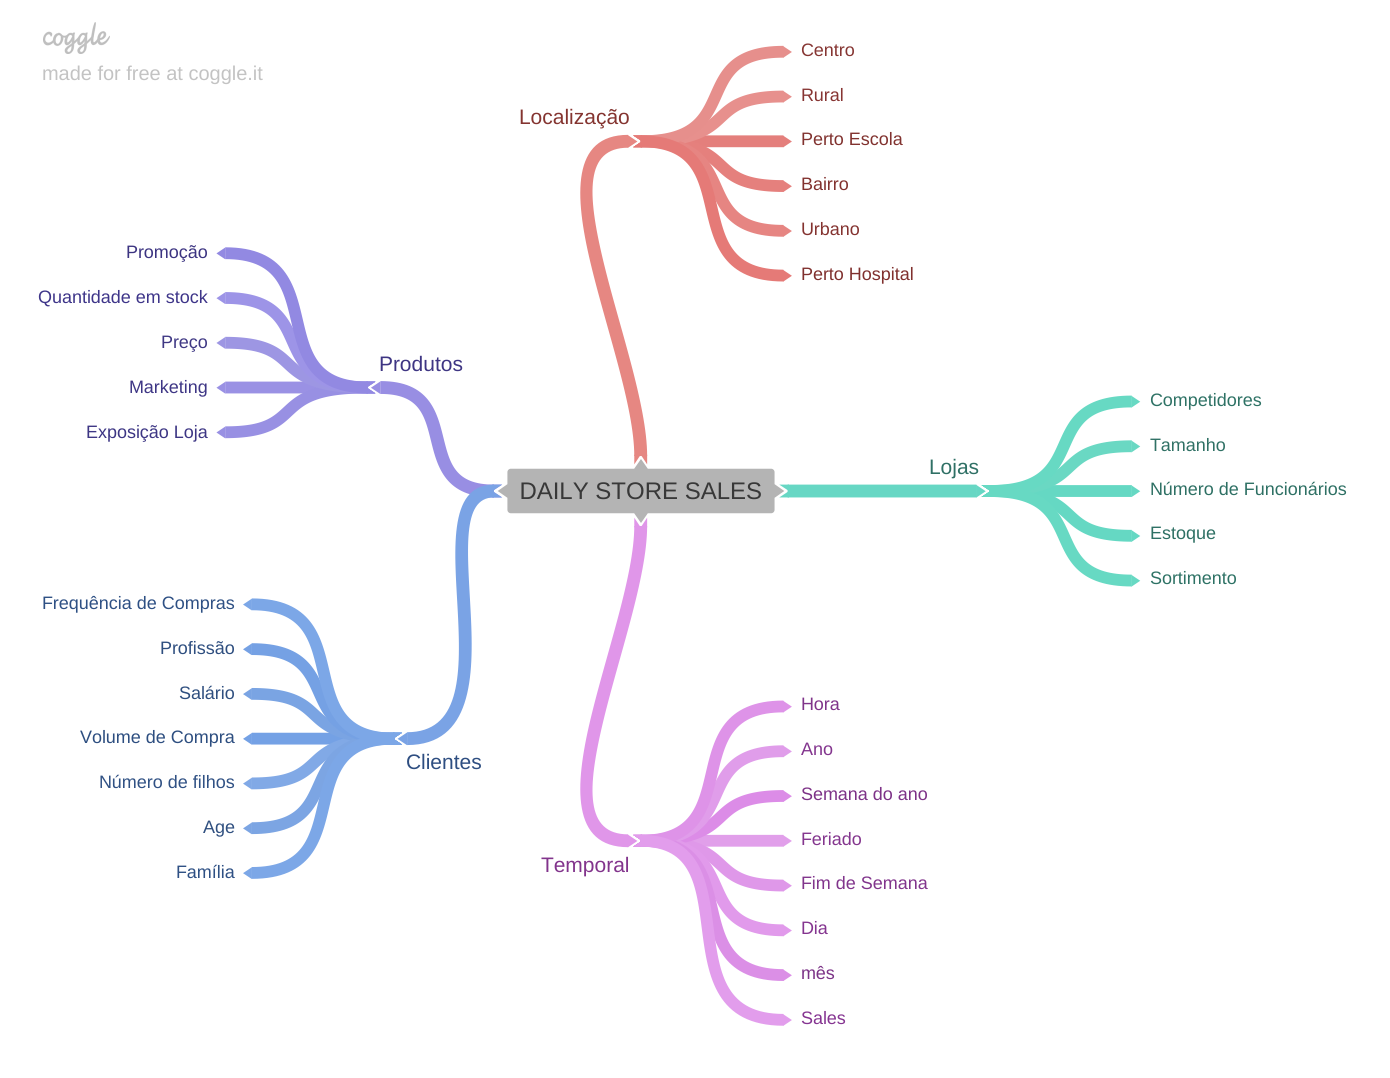

In [46]:
Image('../img/mindmaphypothesis.png')

## <p style="color:#FF0000">2.2 Criação das hipóteses</p>

### <p style="color:#FF0000">2.2.1 Hipóteses Loja</p>

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.**  Lojas com maior sortemento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### <p style="color:#FF0000">2.2.2 Hipóteses Produto</p>

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### <p style="color:#FF0000">2.2.3 Hipóteses Tempo</p>

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## <p style="color:#FF0000">2.3 Lista final de Hipóteses</p>

**1.**  Lojas com maior sortemento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.



**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## <p style="color:#FF0000">2.4 Feature Engineering</p>

Ano, mês, dia, dia da semana, ano da semana são necessários para análises temporais.

Competition Since é interessante pois precisa-se da data correta, competition since está quebrada em mês e ano e é preciso juntar os dois. Como não se tem o dia, será considerado dia = 1.

Competition time month faz a diferença entre data e a competition_since, pois aí é possível saber exatamente a data de início da competição.

Promo Since de inicio junta o ano e a semana, para então depois converter em data

Assortment e State_holiday substituídos pelos nomes descritos pela própria equipe da Rossmann no Kaggle.

In [47]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] ,
                                                                 month= x['competition_open_since_month'], 
                                                                 day= 1 ), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days = 7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 
                                                  'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\ASPIRE~1\AppData\Local\Temp/ipykernel_17268/3938735126.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [48]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# <p style="color:#FF0000">3.0 FILTRAGEM DE VARIÁVEIS</p>

A motivação para realizarmos uma filtragem de variáveis é por restrição de negócio. As vezes pode existir variáveis que impactam diretamente o resultado, porém não é possível ter acesso a ela antes do modelo já estar em produção.

In [49]:
df3 = df2.copy()

In [50]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## <p style="color:#FF0000">3.1 Filtragem das linhas</p>

Aqui, só interessa se a loja está aberta e os dias que houveram vendas.

In [51]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## <p style="color:#FF0000">3.2 Seleção das colunas</p>

Por questão de restrição do negócio, precisamos tirar customers. Esta feature diz quantos clientes tiveram naquele dia, porém, não é possível prever quantos clientes terá daqui a 6 semanas. Teria que ser outro projeto só para descobrir isso.

Open também é removida pois não há um aprendizado para a máquina aqui. Loja aberta tem (ou não) vendas, mas loja fechada é sempre venda 0. Como foi retirado as linhas com open = 0, o que se tem em open é uma coluna só com 1.

promo_interval e month_map foram auxiliares para criar colunas novas.

In [52]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [53]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# <p style="color:#FF0000">4.0 ANÁLISE EXPLORATÓRIA DE DADOS</p>

A motivação para ser feita EDA começa se baseando em entender como as variáveis impactam o fenômeno e qual a força desse impacto. A EDA serve para medir o impacto das variáveis na variável resposta e, se possível, quantificar o impacto. Uma outra importância de uma EDA bem feita é conseguir prever quais variáveis são mais importantes para o modelo de Machine Learning.

A EDA é constituída de 3 análises diferentes:

-- Univariada: Considera-se apenas uma variável, calcula-se min, max, range, entre outros.

-- Bivariada: Considera como uma variável impacta na resposta. Ou seja, faz cálculo de correlações, validações de hipóteses, etc

-- Multivariada: Mais de uma variável em relação a variável resposta ou em relação a elas mesmas. Fazendo correlações, entre outras análises.

In [54]:
df4 = df3.copy()

## <p style="color:#FF0000">4.1 Análise Univariada</p>

### <p style="color:#FF0000">4.1.1 Response Variable</p>

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

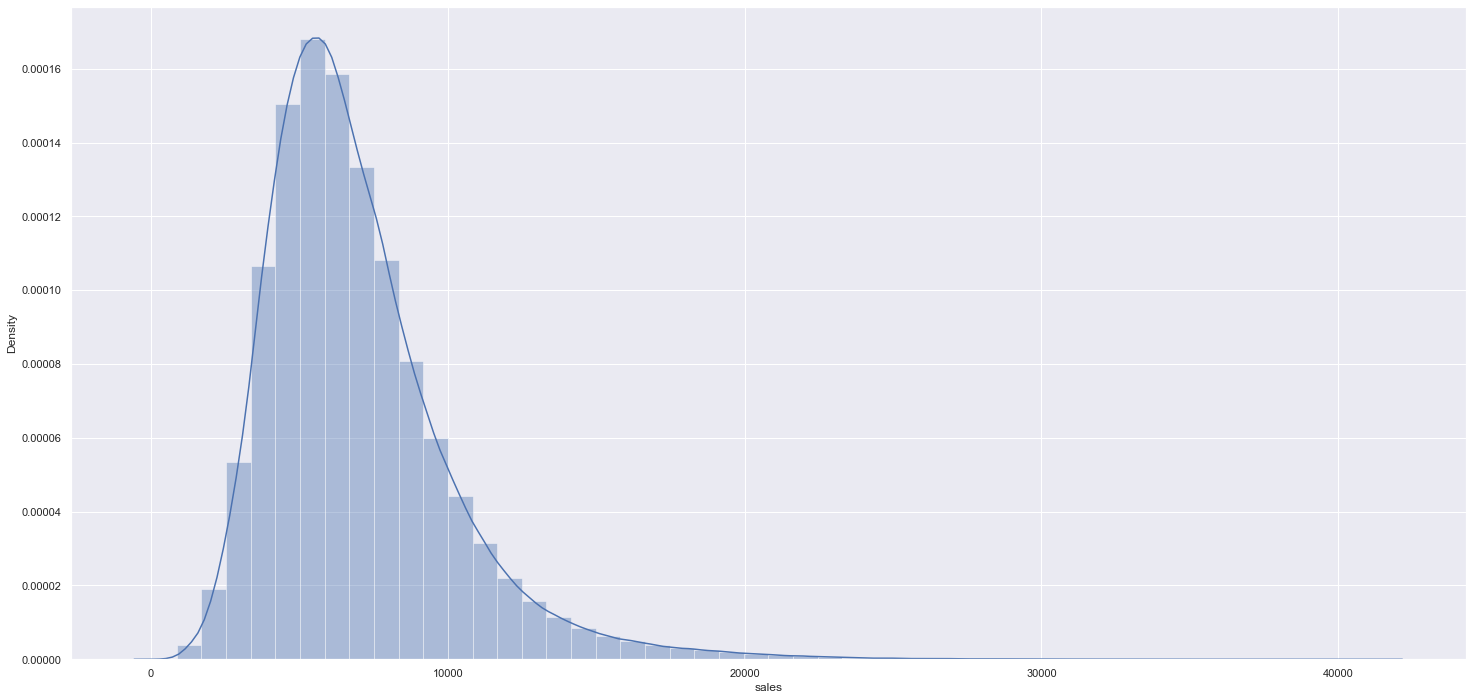

In [55]:
sns.distplot(df4['sales'])

Observa-se aquilo já comentado anteriormente sobre o formato de sales, só confirmado agora. É importante observar como os dados se comportam, pois os modelos de Machine Learning são desenvolvidos de forma a serem independentes e normalmente distribuídos, ou seja, que siga uma distribuição normal. Então, quanto mais próximo de uma normal, melhor será o resultado do algoritmo. Existem várias técnicas para transformar a variável resposta e torná-la o mais próximo possível de uma normal, por exemplo, é possível usar o log da variável, de forma que sofra um deslocamento.

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

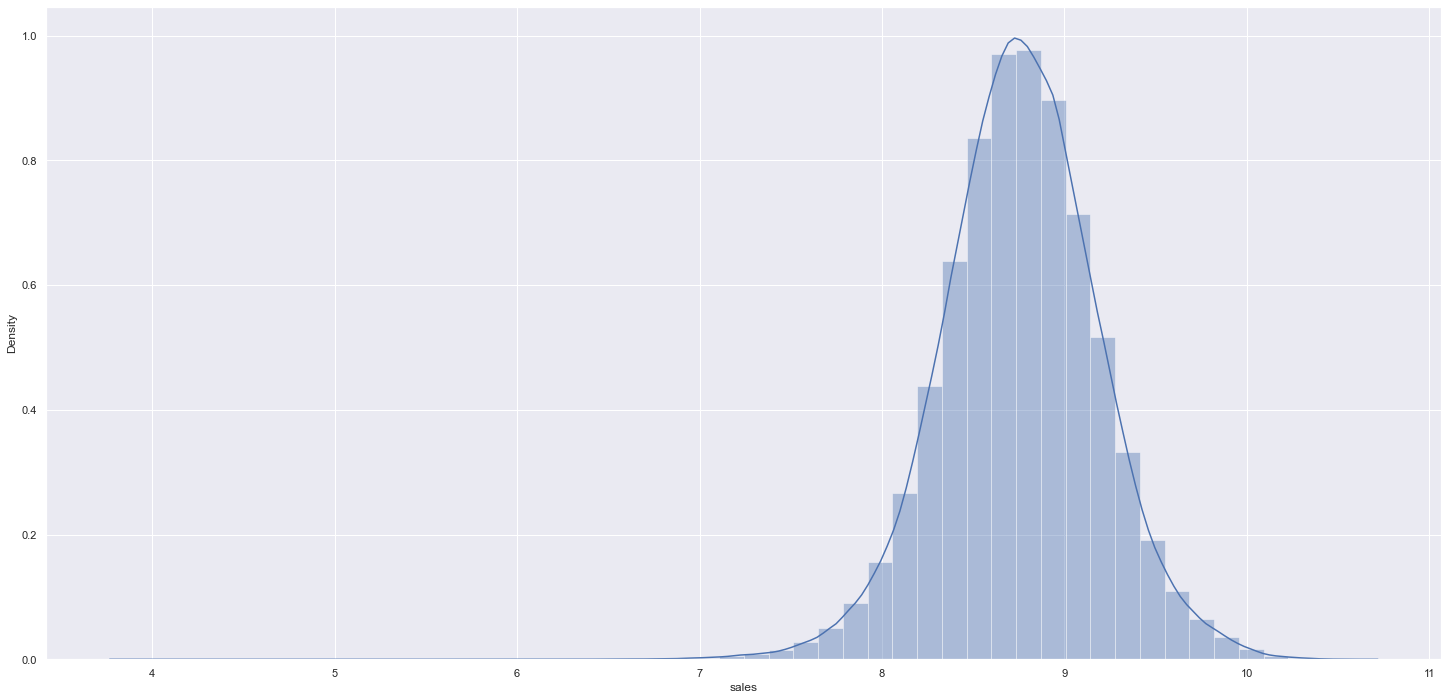

In [56]:
sns.distplot(np.log1p(df4['sales']))

É possível observar o deslocamento e a aproximação de uma normal. Para cada problema a solução será diferente, de forma que é necessário o entendimento do negócio para resolver

### <p style="color:#FF0000">4.1.2 Numerical Variable</p>

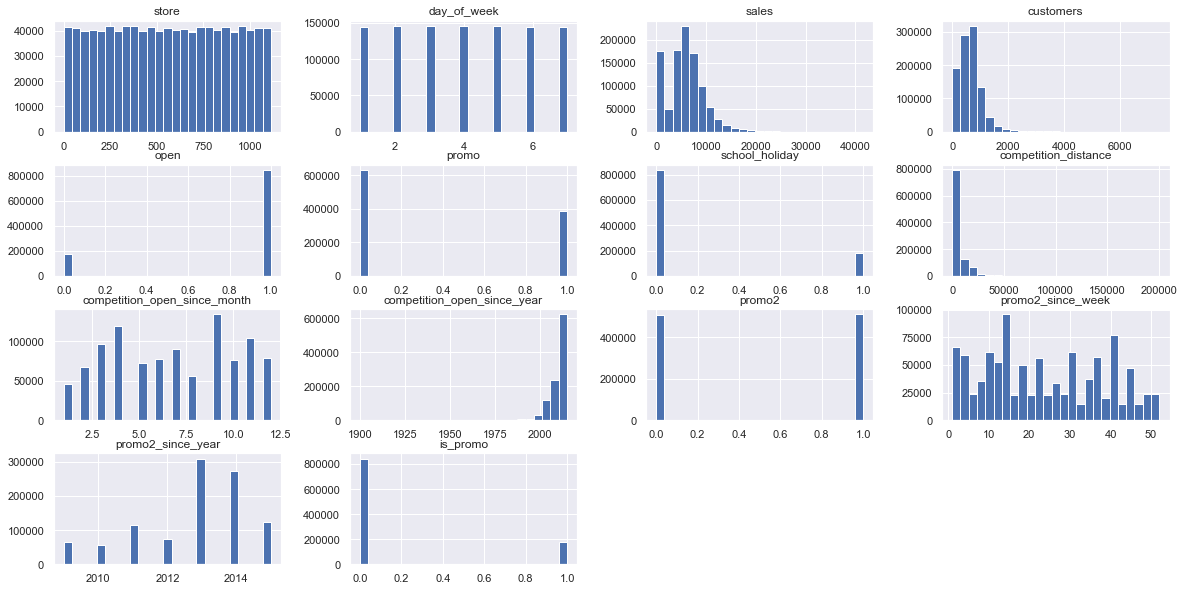

In [57]:
num_attributes.hist(figsize=(20,10),bins = 25);

Em competition distante é possível ver que os dados estão bem próximos, isto é um indicativo que os competidores estão um próximo de outro, como tinha sido visto anteriormente.

Em competition_open_since_month tem-se a distância que o competidor abriu em meses, então temos alguns competidores que abriram faz um mês, com um pico no mês 4. Depois, há uma queda e um crescimento até o mês 8, quando há uma queda brusca para depois, no mês 9, ter o maior pico dentre os meses. Isto é interessante porque, quanto mais comportamentos a variável tenha, mais explicativa do fenômeno ela é. Variáveis como day_of_week são irrelevantes, pois não há uma mudança durante os dias.

Is_promo mostra que há muito mais vendas quando não tem promoção do que quando tem, isso é muito interessante e contra intuitívo, o que pode gerar um insight. 

promo2_since_year é possível ver que há um pico em 2013, é interessante levantar essa discussão pro pessoal de negócio pra entender o que houve nessa época. 

outro ponto a ser levantado é o sales. Apesar do gráfico seguir como uma distribuição normal deslocada para a esquerda, a análise mais profunda nos mostra que existe uma região de queda entre 0 e 5000. É possível levar isso para a equipe pra entender melhor também.

### <p style="color:#FF0000">4.1.3 Categorical Variable</p>

In [58]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

Vamos começar contando quantas linhas se tem em cada uma das variáveis categórica. Por exemplo, em state_holiday, quantas linhas se tem em regular_day, public_holiday, etc. Isso é importante para ter uma ideia de volume, qual tipo de feriado impacta mais.

In [59]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='state_holiday', ylabel='count'>

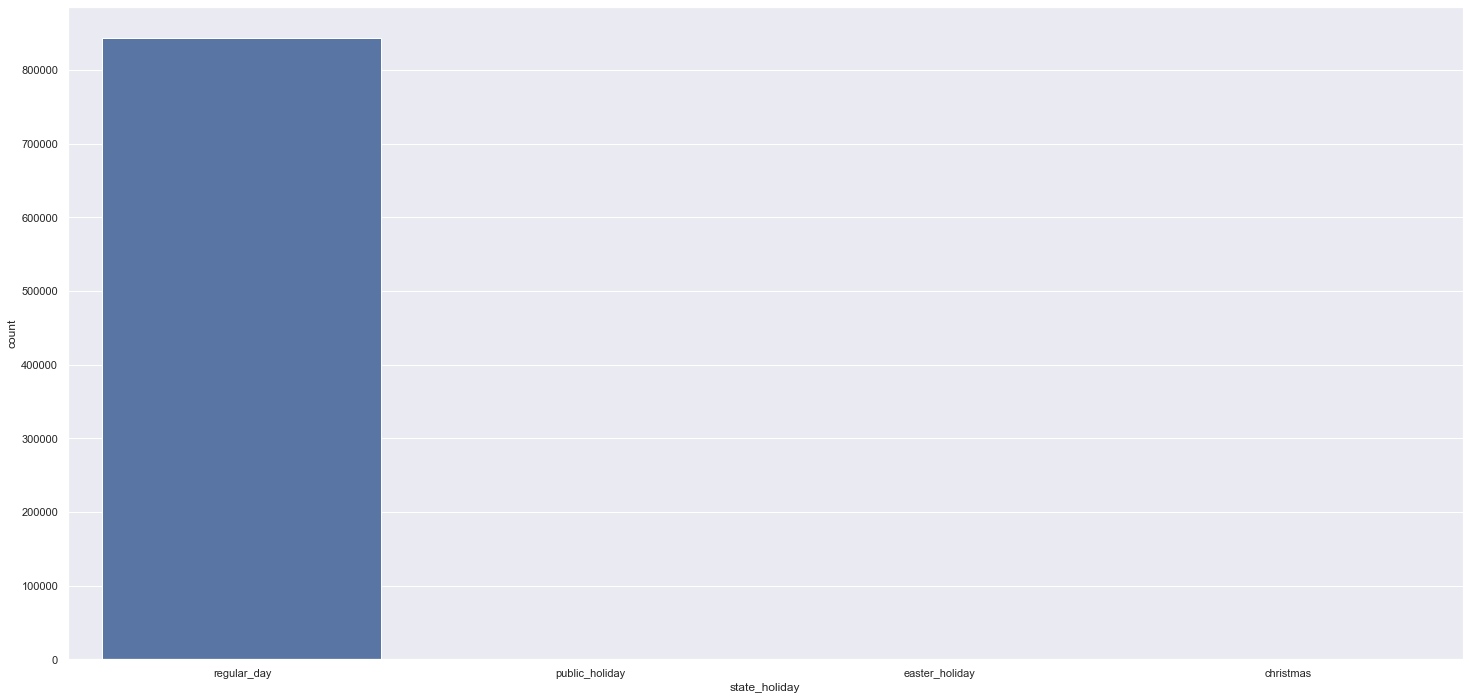

In [60]:
sns.countplot(df4['state_holiday'])

Como é possível ver, existe muito mais regular_day que os outros campos e, por isso, é preciso filtrar, de forma que consigamos ver os feriados.

<AxesSubplot:xlabel='sales', ylabel='Density'>

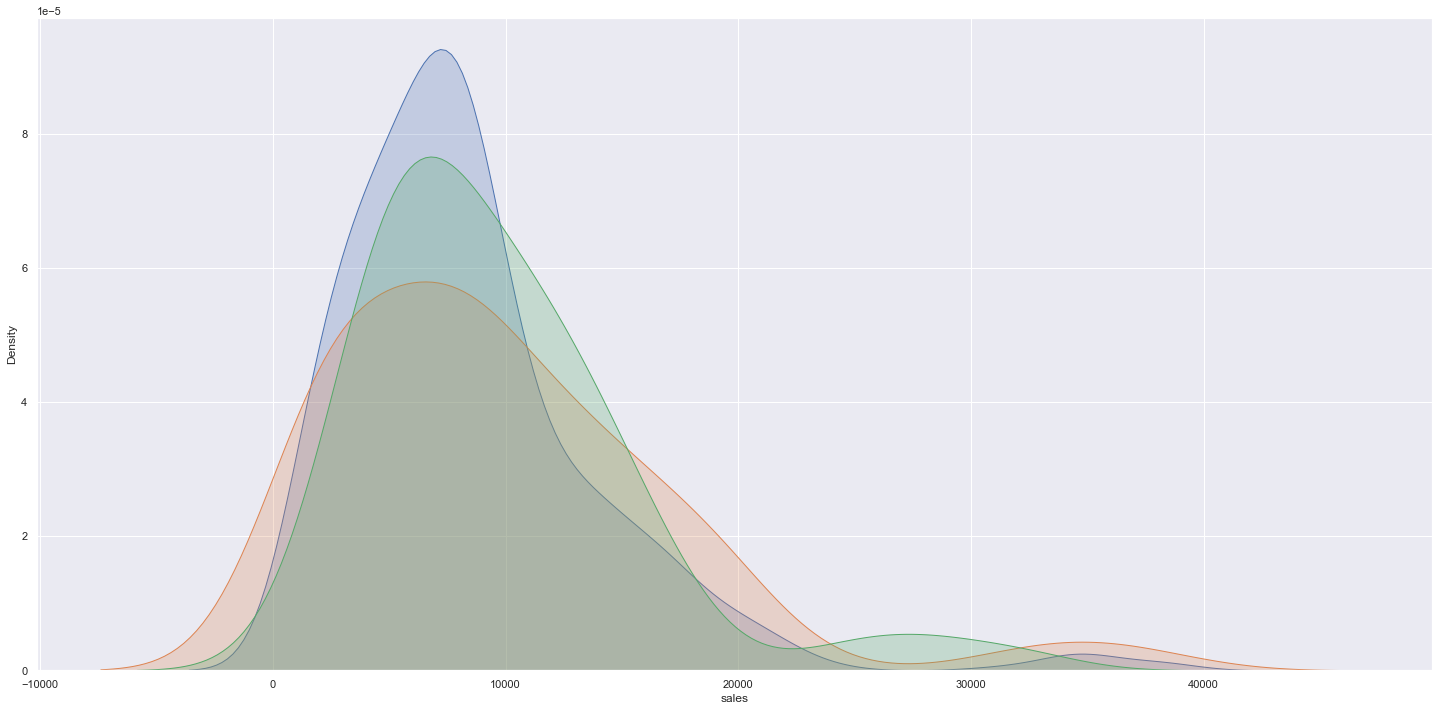

In [61]:
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

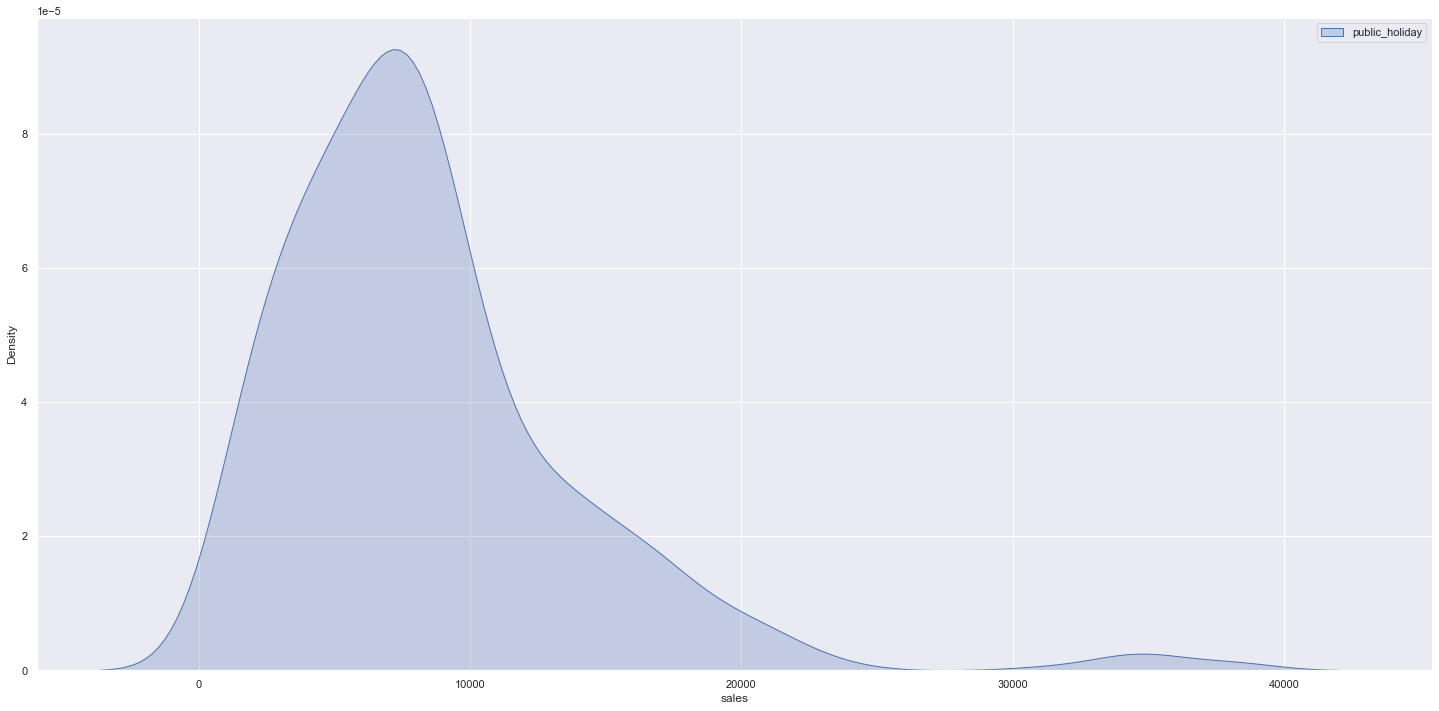

In [62]:
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
plt.legend()

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

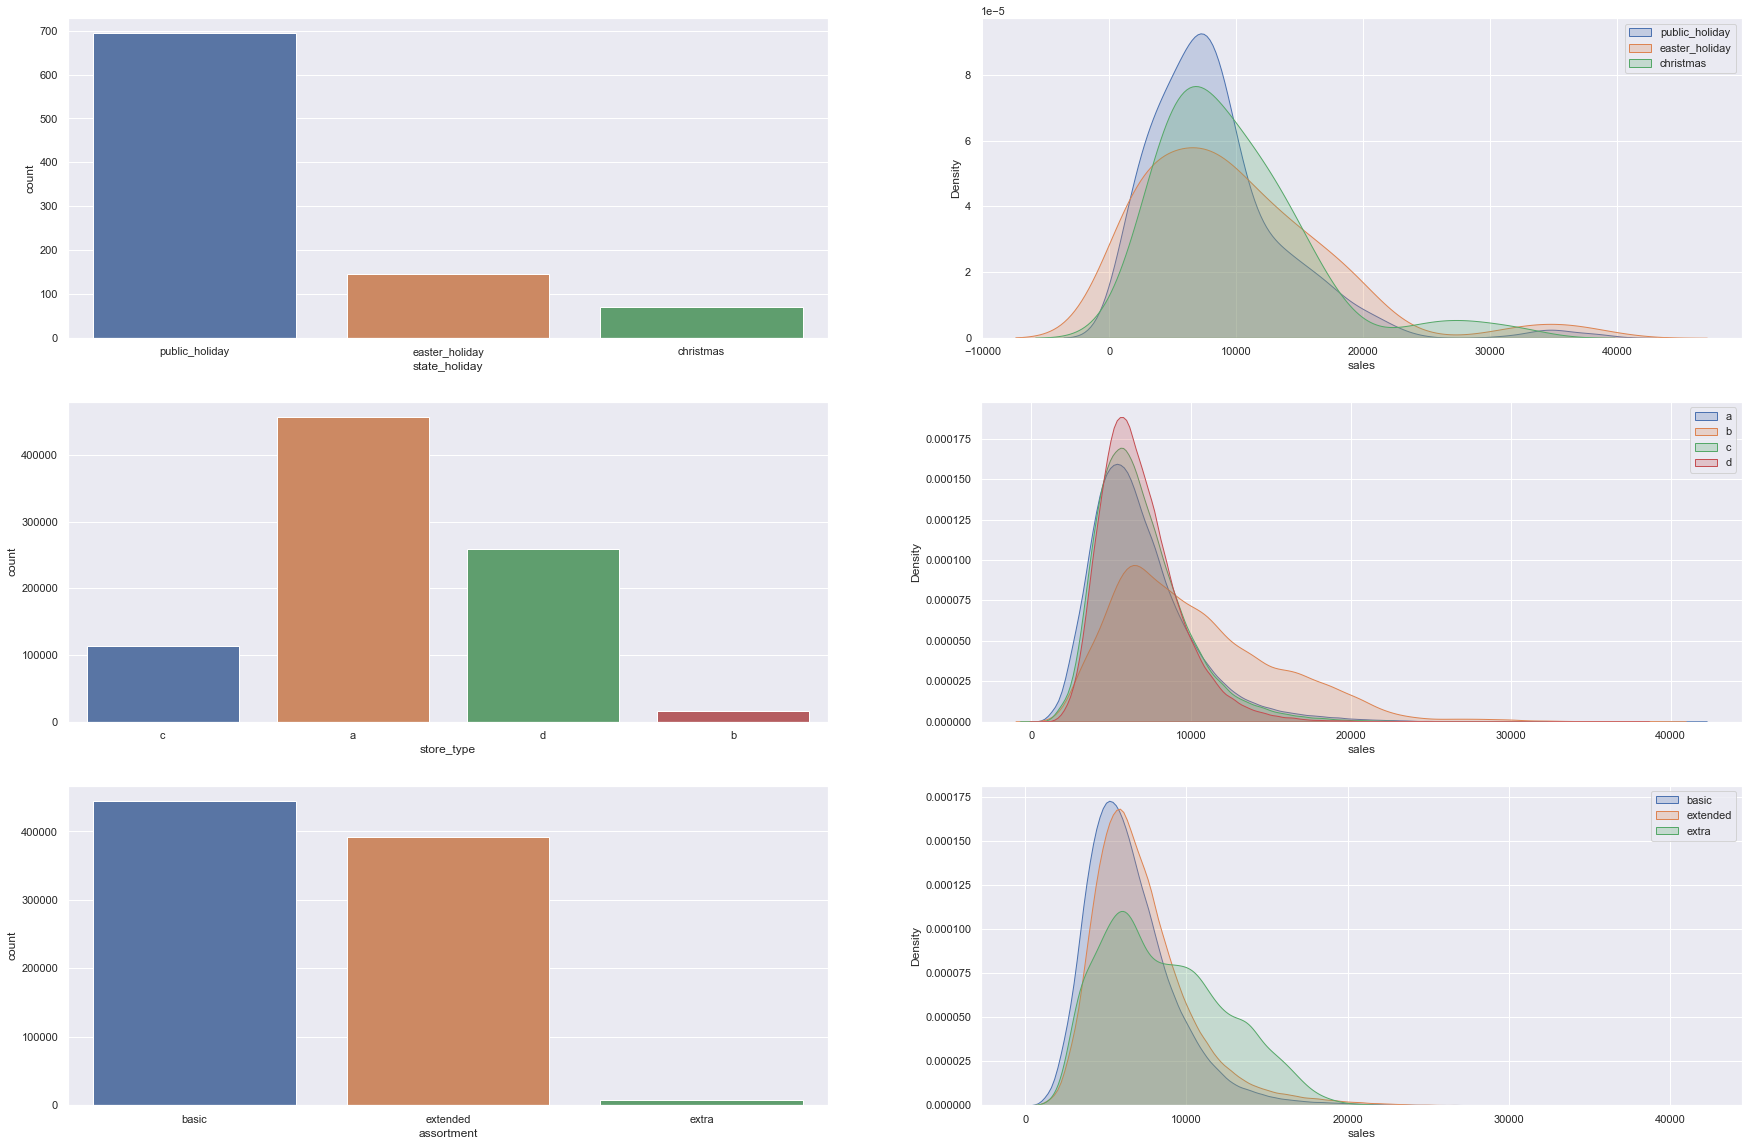

In [63]:
# state_holiday
plt.figure(figsize=(30,20))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()

No gráfico (1,1), é possível observar que existe mais feriados públicos, depois pascoa e depois natal. 

No gráfico (1,2), observa-se que o public_holiday tem um volume muito maior de vendas, ou seja, um pico muito maior. Por outro lado, o christmas tem um menor, mas se observarmos para valores um pouco maiores, o volume de vendas em christmas é maior de todos. Ou seja, podemos entender que, entre as vendas de produtos mais caros, em christmas, mais produtos são vendidos. 

No gráfico (2,1), temos o volume por tipo de loja.

No grafico (2,2), vemos que o tipo de loja d tem um pico maior, porém, o tipo b tem vendas mais bem distribuídas nas faixas de preços. 

No gráfico (3,1), extra é o tipo que menos vende, enquanto basic e extended vendem muito bem.

No gráfico (3,2), o valor de extra é mais baixo, mas mais distribuído. Enquanto basic e extended tem grandes picos de vendas

## <p style="color:#FF0000">4.2 Análise Bivariada</p>

### **H1.**  Lojas com maior sortemento deveriam vender mais.
***Falsa***. Lojas com maior sortimento vendem menos

sortemento é o tipo de produto em relação a variável resposta

<AxesSubplot:xlabel='year_week'>

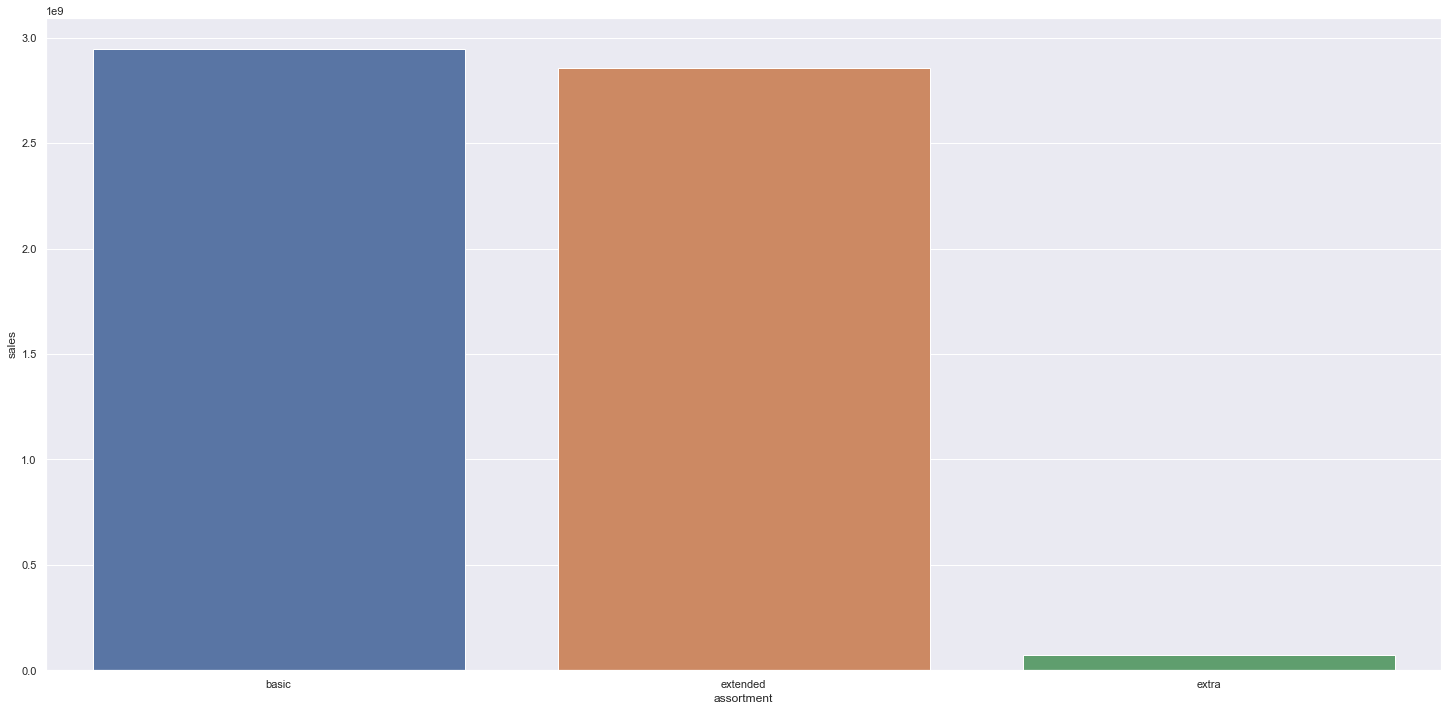

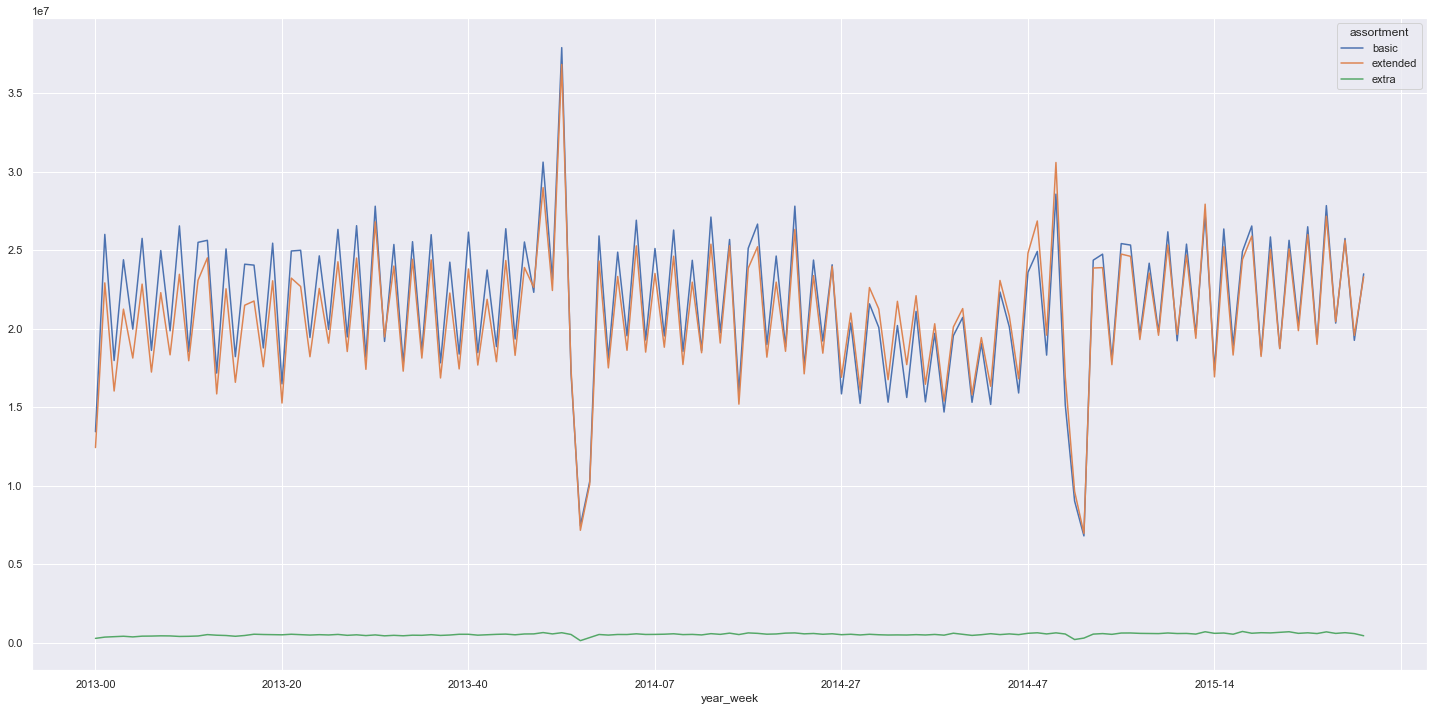

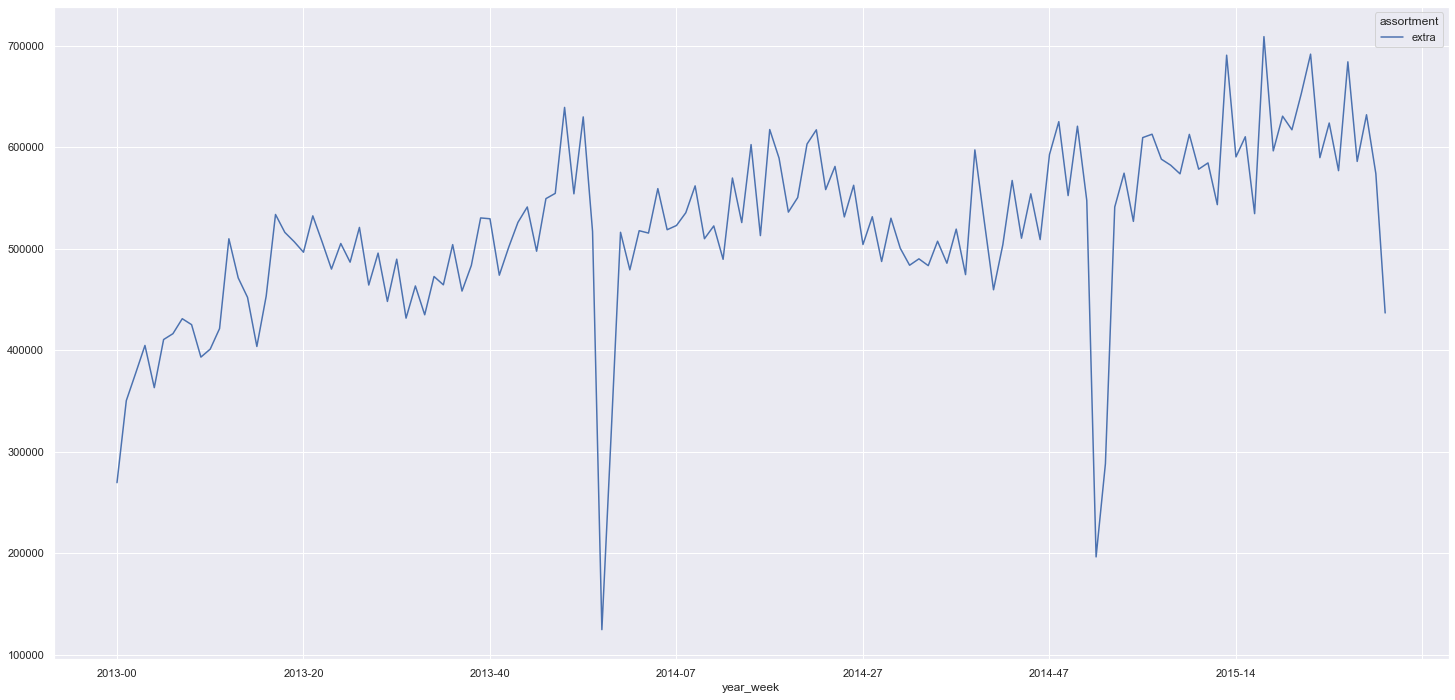

In [64]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns = 'assortment', values = 'sales')
aux3.plot()

aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index='year_week', columns = 'assortment', values = 'sales').plot()

O que se conclui é que basic e extended tem aproximadamente o mesmo volume de vendas, mas o extra tem uma quantidade de venda menor. Aqui foi assumido que extra tem um volume maior, uma vez que não se tem tanta informações sobre o negócio. 

Em seguida, foi feito o gráfico das vendas por semana do ano de todos os tipos de assortment. Observa-se que basic e extended são iguais em termos de comportamento ao longo do tempo, enquanto extra continua pequeno, o que dá pra indicar que de fato extra é bem menor sempre.

Por fim, filtra-se apenas o extra para ver seu comportamento isoladamente, já que por termos basic e extended muito maior, extra virou apenas uma linha.

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
***Falsa***. Lojas com competidores mais próximos vendem mais.

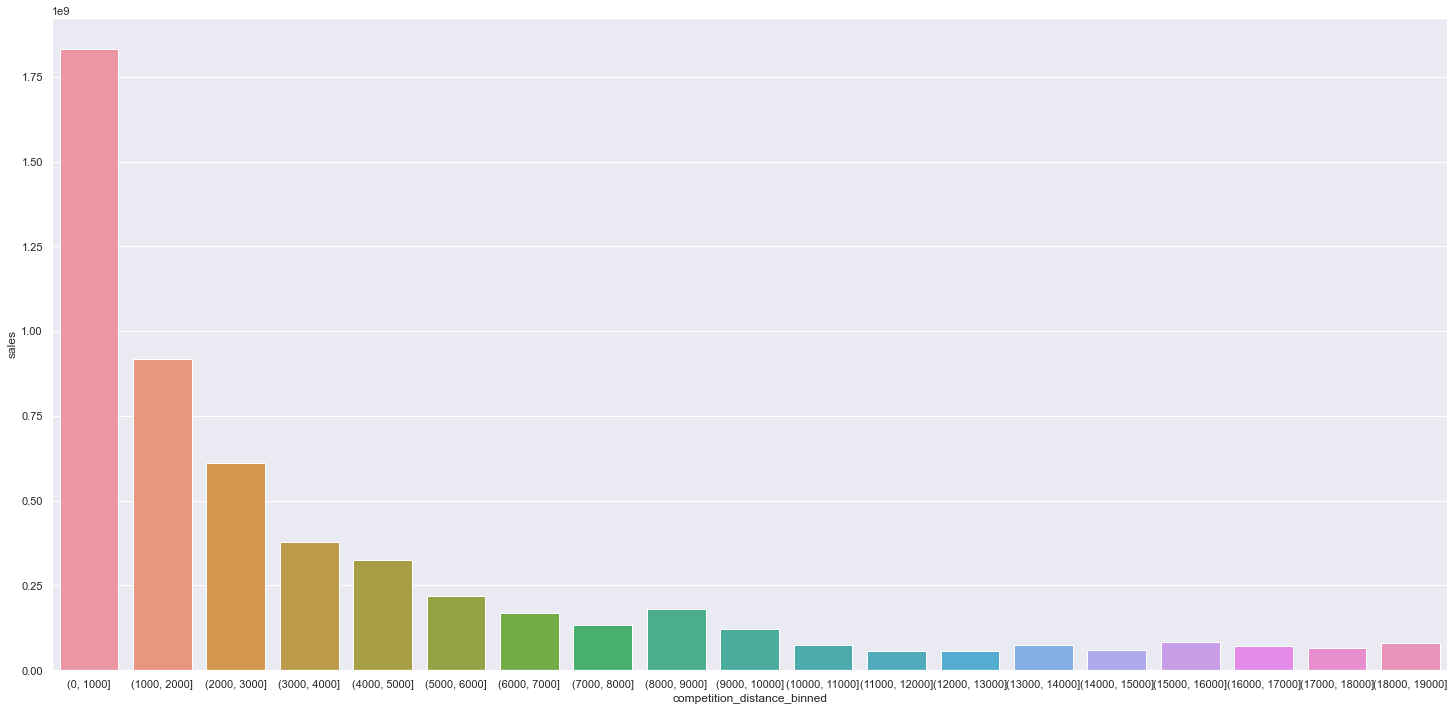

In [65]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2);

Pela lógica, se o competidor estiver mais próximo, a loja venderia menos. Porém, pelos dados, lojas com competidores próximos vendem MAIS. Isto é completamente contra qualquer senso comum. Talvez seja a ideia de que se você tem mais gente vendendo você incentiva as pessoas a irem a região sempre que precisam comprar. 

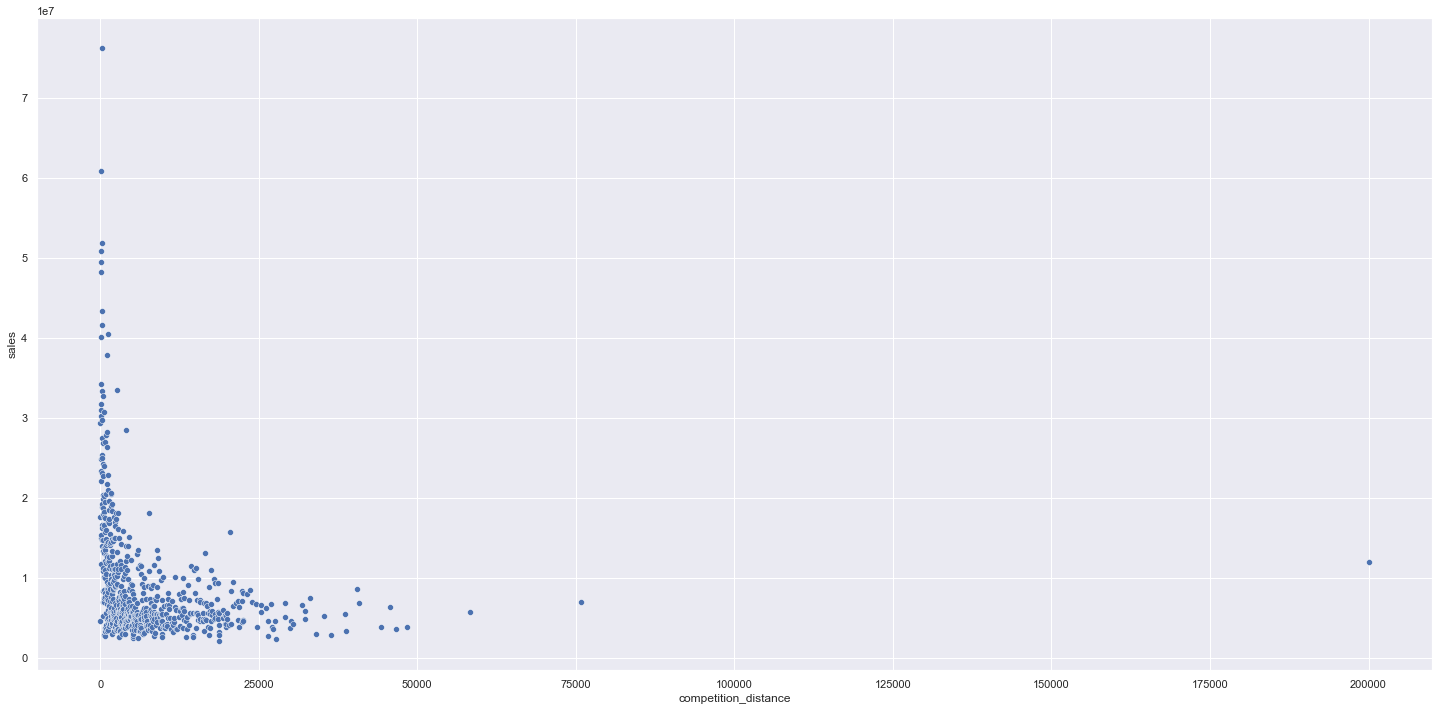

In [66]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x = 'competition_distance', y='sales', data = aux1);

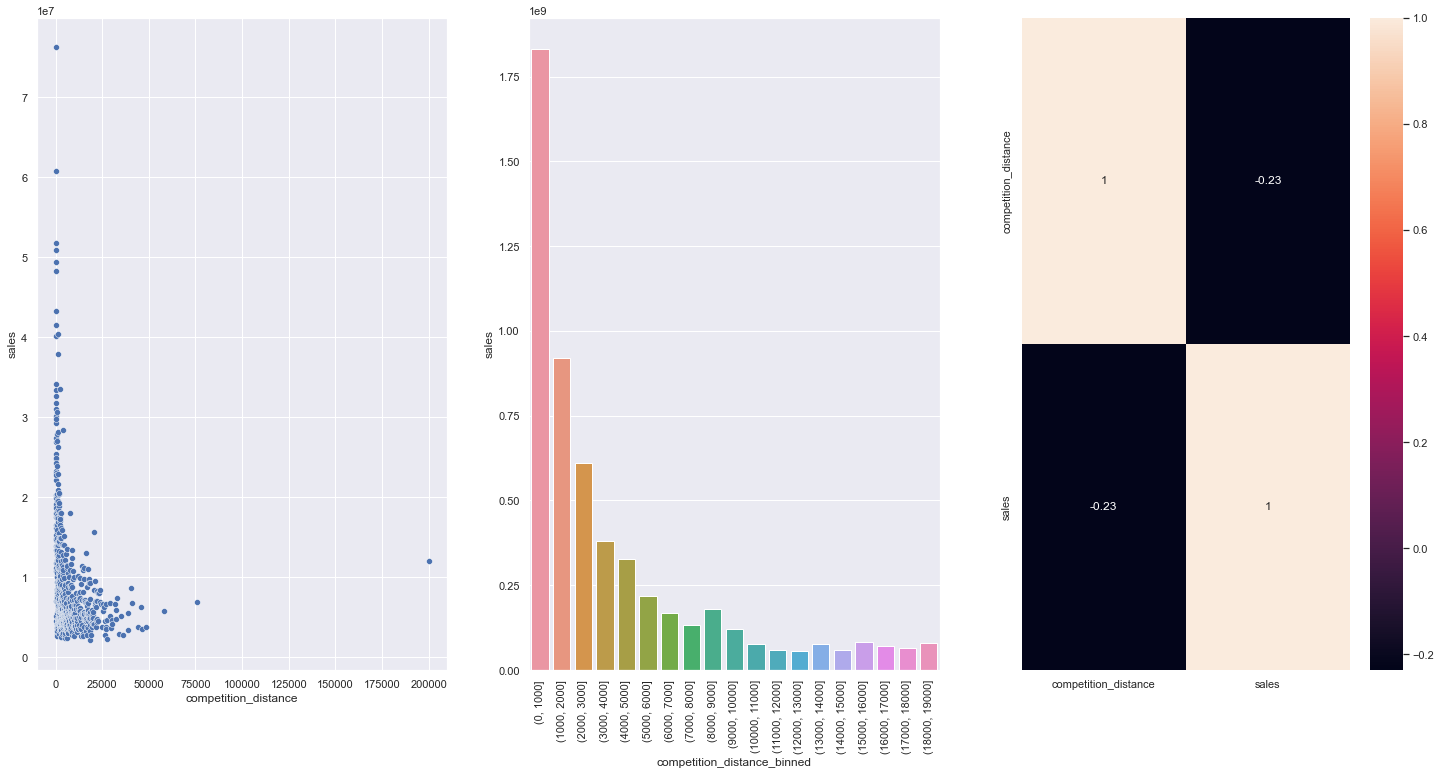

In [67]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

É possível ver a força da correlação da competition distance e as vendas e que a correlação é de -0,23. Lembrando que a correlação varia de 1 até -1, quanto mais próximo de zero mais fraca correlação.

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
***Falsa***. Lojas com competidores à mais tempo vendem menos.

É preciso tomar cuidado com o competition_open_since_month, uma vez que a loja pode ter sido aberta em, por exemplo, maio e a análise esteja sendo em junho, ou seja, o tempo de abertura seria de 1 mês. Porém, se a análise estiver sendo feita em junho do outro ano, o total é de 13 meses. Por isso, é necessário usar a competition_time_month aqui.

<AxesSubplot:>

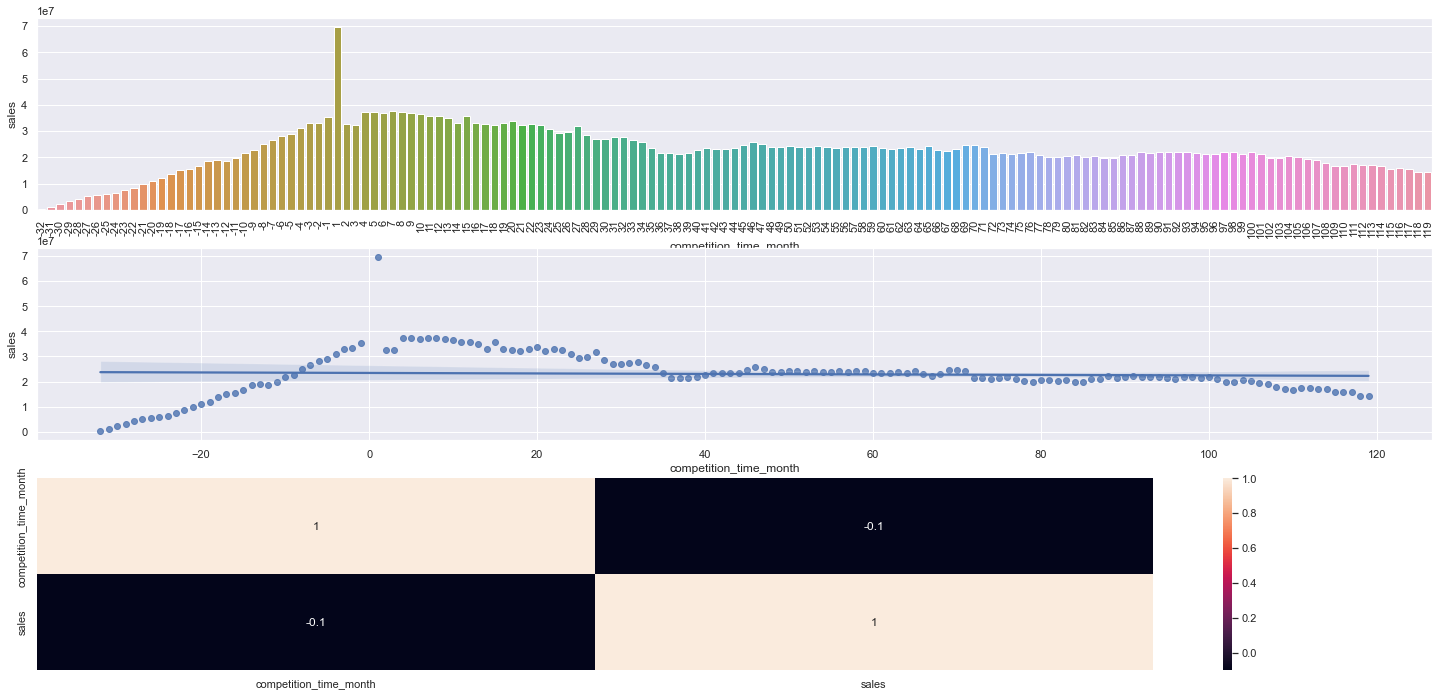

In [68]:
plt.subplot(3,1,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data = aux2);
plt.xticks(rotation=90);


plt.subplot(3,1,2)
sns.regplot(x='competition_time_month', y='sales', data = aux2);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


Na primeira figura observa-se que quanto mais próximo de zero, maior a quantidade de vendas. Ou seja, quanto mais recente a abertura da loja, maior a quantidade de vendas. A segunda figura confirma isso. Quanto maior o tempo de competição, mais a vendas caem. O pico se encontra em 0. 

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

Vamos analisar agora utilizando a variável derivada anteriormente, a promo_time_week. Ela informa a quanto tempo a promoção foi ativa.
Se promo_time_week for positivo, é indicativo de que a compra foi feita em período promocional. Caso seja negativo é indício de que a loja ainda entrará em promoção estendida.

In [69]:
import matplotlib.gridspec as GridSpec

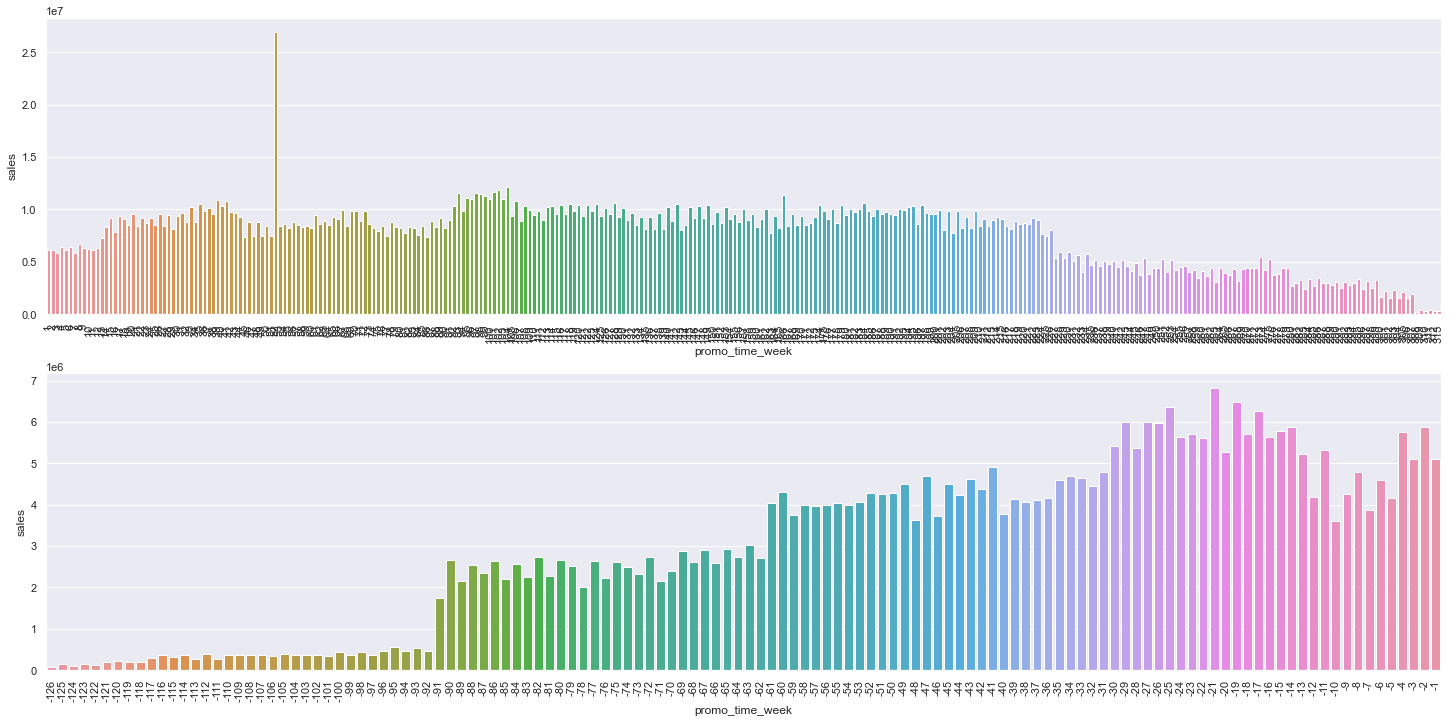

In [70]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec.GridSpec( 2,2 )

plt.subplot( grid[0,:] )
aux2 = aux1[aux1['promo_time_week']>0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot( grid[1,:] )
aux3 = aux1[aux1['promo_time_week']<0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data = aux3);
plt.xticks(rotation=90);

Observando a promoção estendida (gráfico 1), ele tem um patamar de vendas nos primeiros dias e se mantém até um certo tempo e depois começa a cair. Ou seja, a promoção estendida tem um tempo determinado de funcionamento, depois desse período ela tem uma queda, então não adianta manter uma promoção estendida por muito tempo. 

Nas promoções regulares (gráfico 2) o comportamento é de que, se a promoção é "avisada" muito antes a loja não tem aumento de vendas, porém, quanto mais próximo da promoção estendida maior a quantidade de vendas. 

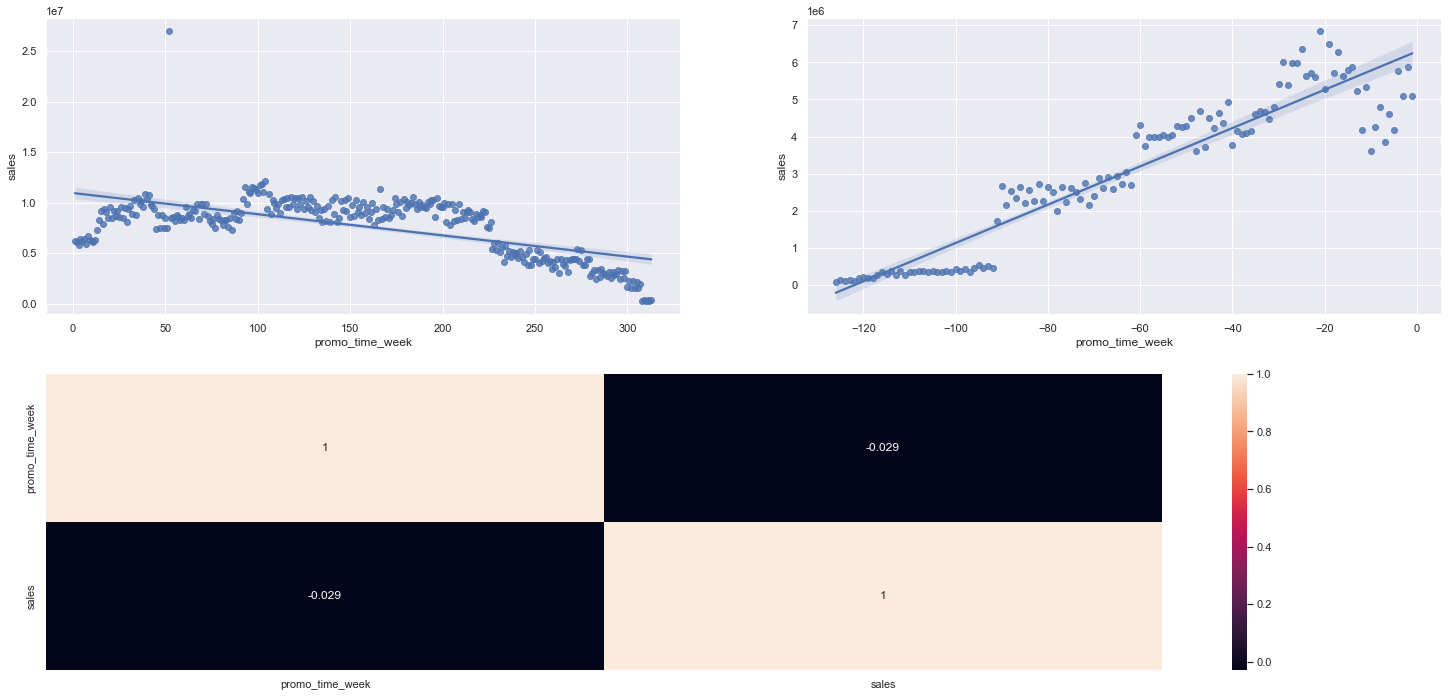

In [71]:
grid = GridSpec.GridSpec( 2,2 )

plt.subplot( grid[0,0] ) #promo extendido
sns.regplot(x='promo_time_week', y='sales', data = aux2);

plt.subplot(grid[0,1]) #promo regular
sns.regplot(x='promo_time_week', y='sales', data = aux3);

plt.subplot( grid[1,:] )
sns.heatmap(aux1.corr(method='pearson'), annot = True);

Observando a correlação, existe uma correlação muito fraca, de forma que esta variável possivelmente não influencie no resultado do modelo.

### H5. Lojas com mais dias de promoção deveriam vender mais.

#### Será feito no próximo ciclo.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa*** Lojas com mais promoções consecutivas vendem menos.

In [72]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


É possível ver que o menor valor é quando a loja participou só da promo2, as lojas que participaram das duas pomoções venderam semelhante a quando não tinha promoção alguma. As lojas que participaram apenas da promoção normal venderam mais. Ou seja, não tem muita vantagem participar da promoção estendida. 

Observa-se se esse comportamento muda ao longo do tempo, para isso, é possível analisar as lojas que tiveram a promoção tradicional e seguiram para a estendida e as lojas que foram direto para promoções estendidas. 

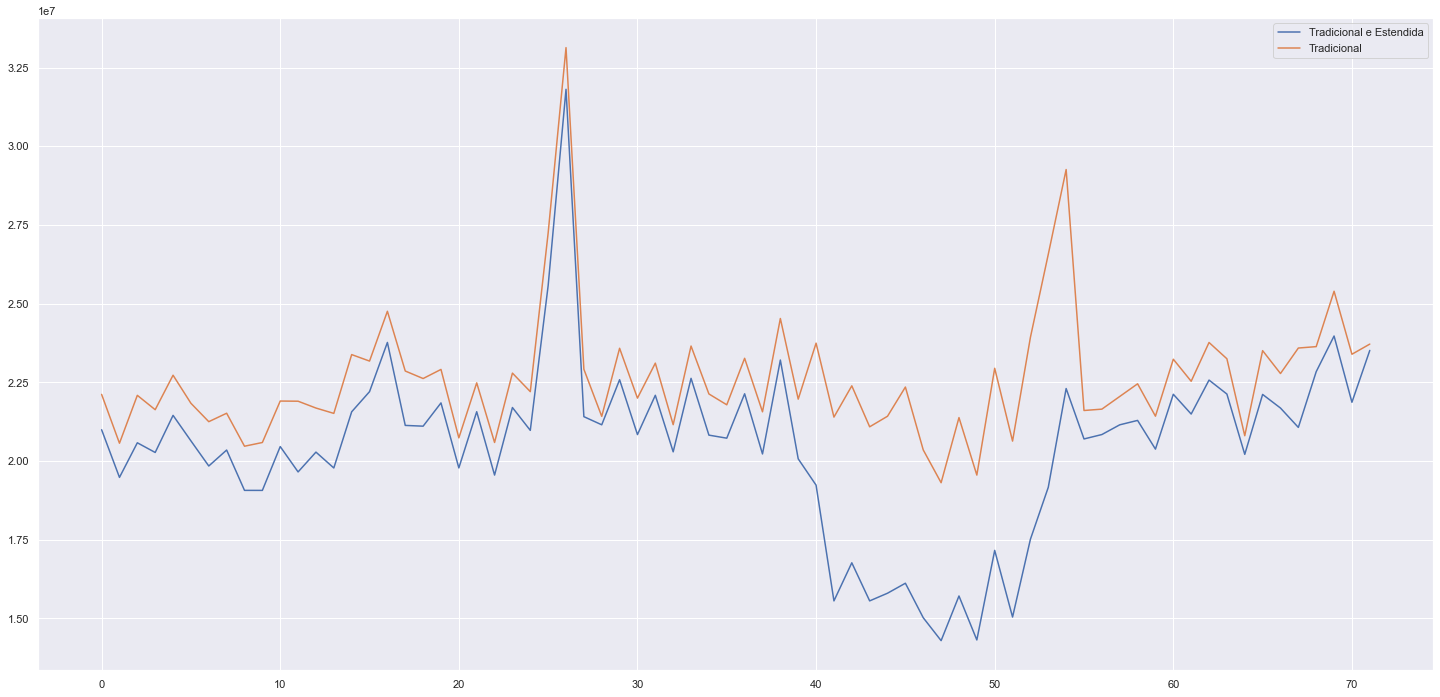

In [73]:
aux1 = df4[(df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels=['Tradicional e Estendida', 'Tradicional'])

As vendas para tradicional + estendida foram menores. Além disso, observando o gráfico não se encontra nenhum comportamento relevante no modelo, ou seja, não há uma relevância da variável para um modelo.

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de Natal vendem menos.

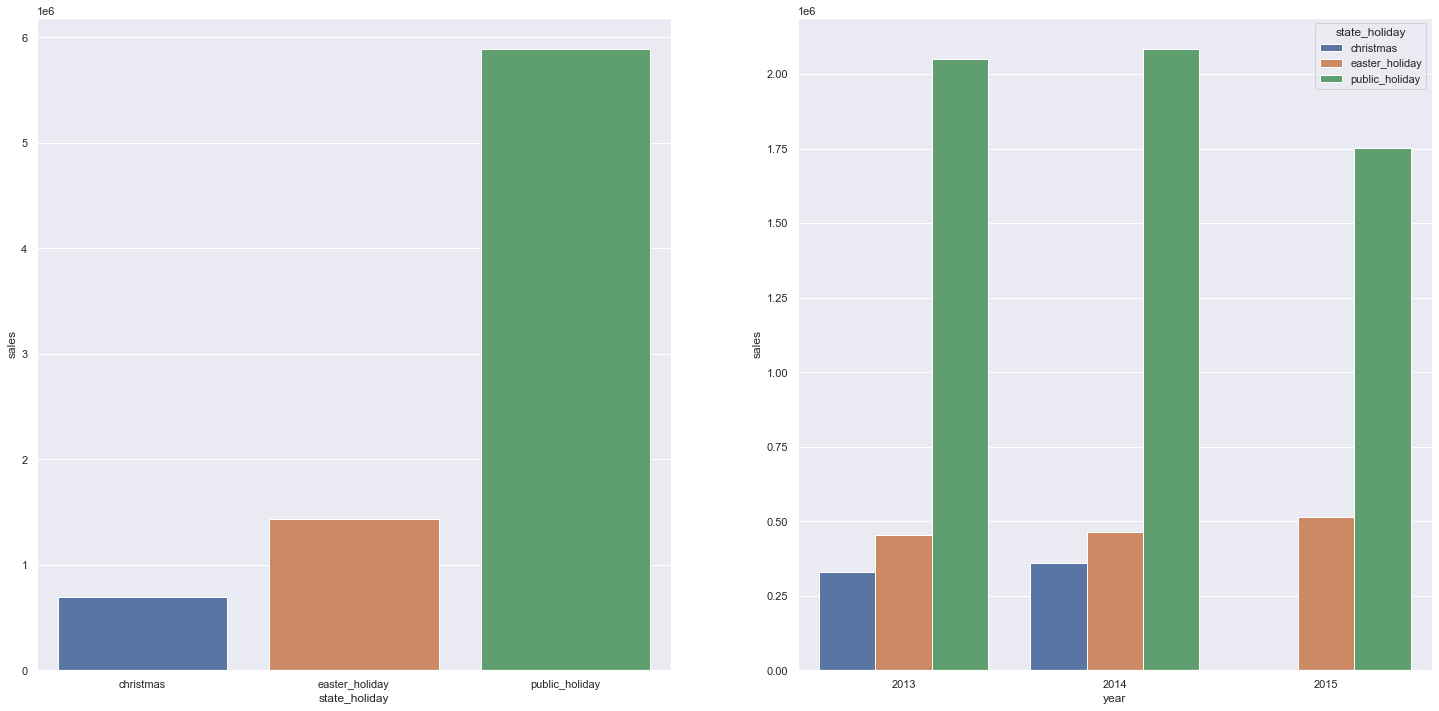

In [74]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y = 'sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y = 'sales', hue = 'state_holiday', data=aux2);

É possível ver que os feriados públicos tem muito mais vendas. O Natal é o que menos tem e esse comportamento ocorre nos últimos anos da análise. Além disso, foi necessário remover os dias regulares pelo fato de serem muito mais dias. No ano de 2015 não há natal, pois os dados vão até agosto de 2015.

### H8. Lojas deveriam vender mais ao longo dos anos.
***Falsa*** Lojas vendem menos ao longo dos anos.

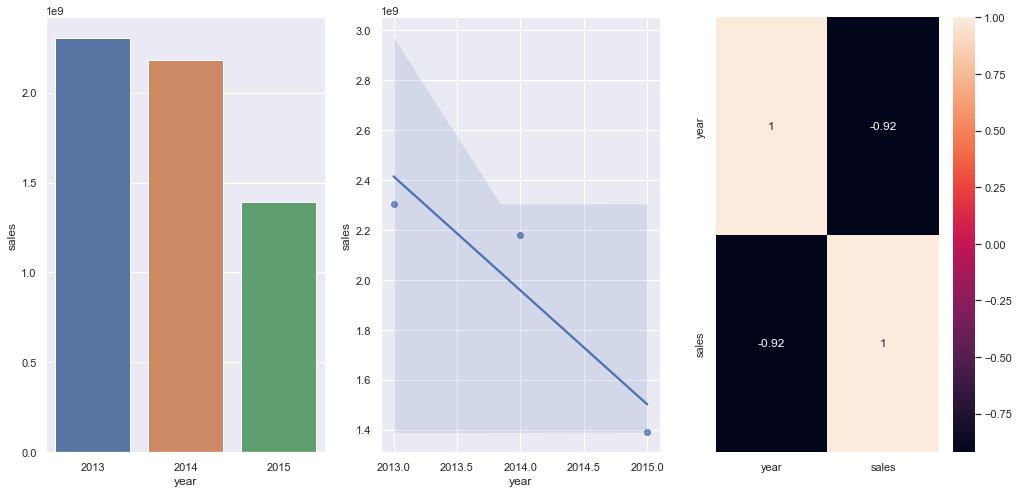

In [75]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(1,3,1)
sns.barplot(x='year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

Observa-se uma queda entre os anos e a tendência é de decaimento. E, pelo heatmap, é possível ver que sales e year são fortemente correlacionada negativamente. Isso não é uma informação tão correta, devido ao fato de 2015 não estar completo, essa tendência de caimento vem muito mais forte. Para uma melhor análise é melhor pegar períodos fechados.  

### H9. Lojas deveriam vender mais no segundo semestre do ano.
***Verdadeira*** Lojas vendem mais no segundo semestre do ano.

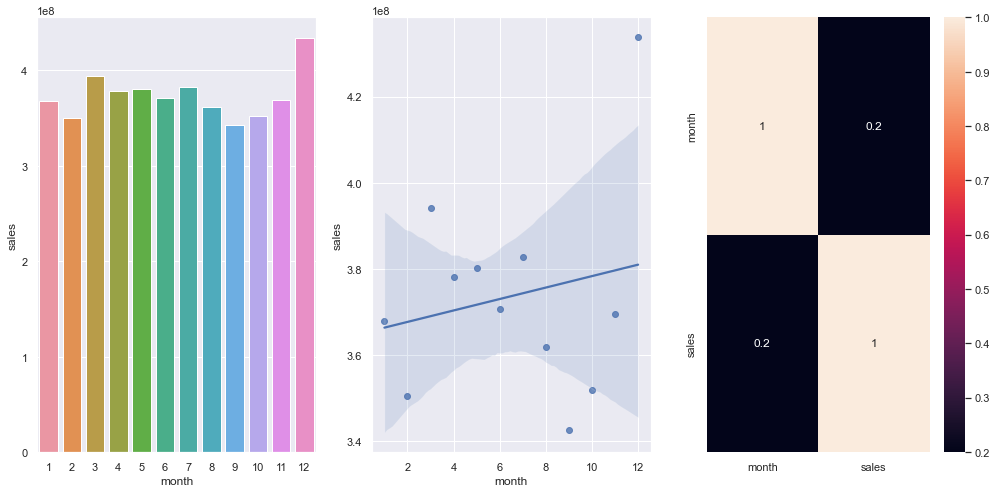

In [76]:
aux = df4[df4['year'] != 2015]
aux1 = aux[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(1,3,1)
sns.barplot(x='month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

Existe um claro crescimento de vendas nos últimos meses. Aqui foi feito um filtro no ano para tirar o ano de 2015, se não os dados não seriam fiéis.

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mês.

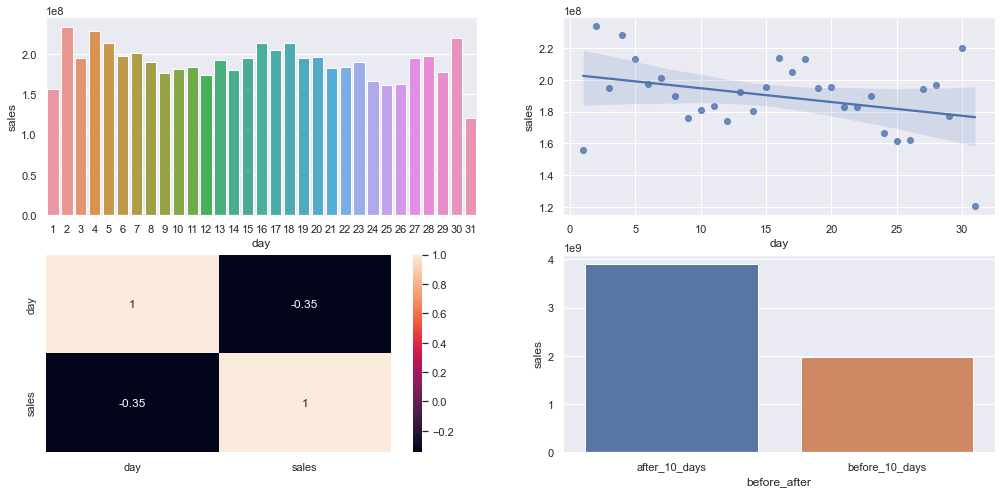

In [77]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(2,2,1)
sns.barplot(x='day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y = 'sales', data=aux2);

Esta análise talvez seja um pouco injusta, pois a análise é de apenas 10 dias com pelo menos 20 dais (o resto do mês). Talvez a ideia fosse analisar se nos primeiros 10 dias, quando, em geral, as pessoas recebem o salário, os gastos são maiores, porém, esta hipótese é falsa.

In [78]:
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux1.tail()

,day,sales,before_after
26,27,194264879,after_10_days
27,28,196952797,after_10_days
28,29,177114239,after_10_days
29,30,219939617,after_10_days
30,31,120659889,after_10_days


### H11. Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** Lojas vendem menos nos finais de semana.

In [79]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


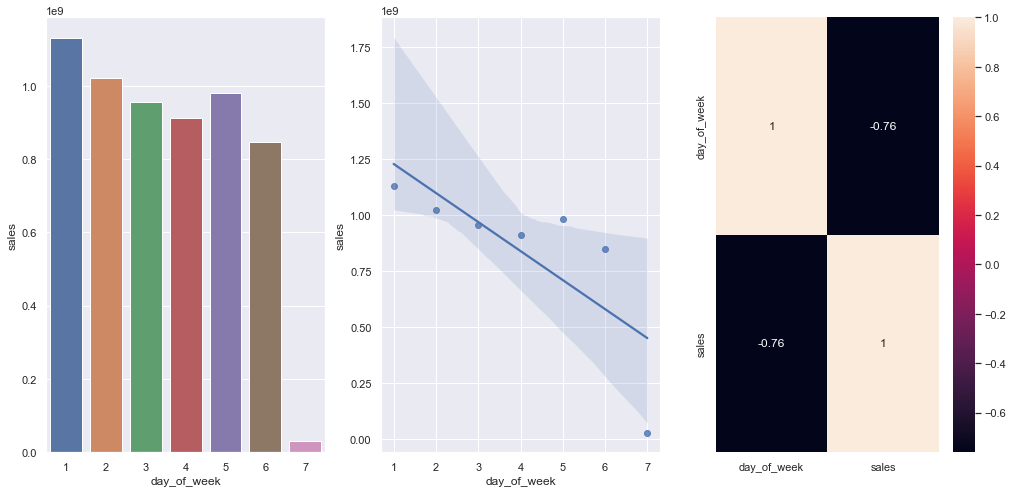

In [80]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(17, 8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

Conforme o fim de semana se aproxima, as vendas caem. O domingo é o que vende menos, talvez algumas lojas não funcionem no domingo, o que faz as vendas gerais caírem muito.

### H12. Lojas deveriam vender menos durante os feriados escolares.
***Verdadeira*** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

In [81]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


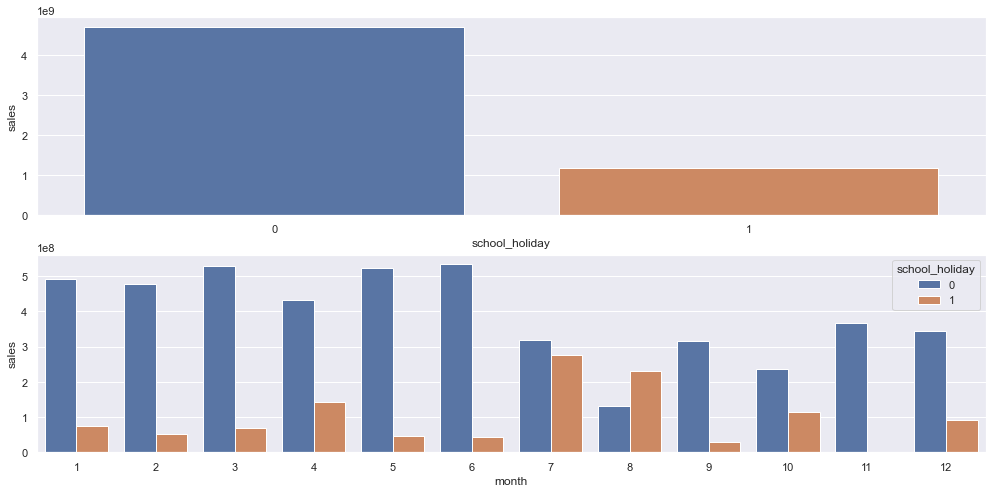

In [82]:
plt.figure(figsize=(17, 8))
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y = 'sales', hue='school_holiday', data = aux2);

As vendas são sempre menores, porém, se observar os meses de Julho, as vendas se equiparam. A possível explicação para isso é o fato de que em Julho temos férias escolares, o que pode ser considerado como feriado. 

### 4.2.1 **Resumo das hipóteses**

In [83]:
from tabulate import tabulate

In [84]:
tab = [['Hipóteses', 'Conclusao', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'], 
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Verdadeira', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
      ]
print(tabulate(tab,headers='firstrow'))

Hipóteses    Conclusao    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## <p style="color:#FF0000">4.3 Análise Multivariada</p>

Agora é feito uma análise para entender como as variáveis se relacionam uma com as outras e também com a variável resposta. 

A motivação para fazer uma análise multivariada é de diminuir a dimensionalidade do modelo, de forma que os modelos de machine learning performem de uma forma mais eficiente. Uma forma de reduzir a dimensionalidade é observar se duas colunas do dataset tem as mesmas quantidades de informações, ou seja, se a correlação entre as variáveis for igual a 1. Isso vem dos vetores LI, se eles são independentes entre si, é possível tratá-los separadamente.

### <p style="color:#FF0000">4.3.1. Numerical Attributes</p>

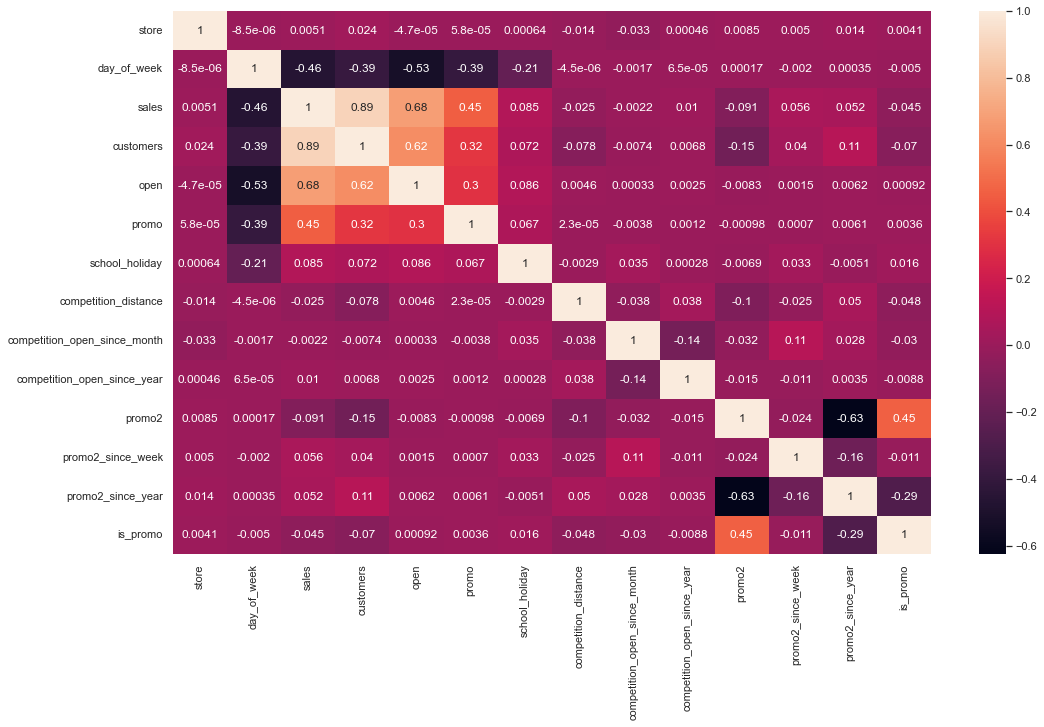

In [85]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(17, 10))
sns.heatmap(correlation, annot = True);

Quanto mais perto da cor preta, mais correlacionado negativamente as nossas colunas, quanto mais próximo da cor clara, maior a correlação positiva. É possível ver que costumers tem uma correlação muito forte com várias features, porém, já foi mostrado que não será possível utilizá-la. Vemos que nenhuma correlação é próxima suficiente de 1 para serem excluídas.

### <p style="color:#FF0000">4.3.2. Categorical Attributes</p>

Foi utilizado até agora o método de Pearson, entretanto, este método só funciona se utilizado variáveis numéricas. Agora, será necessário usar o método de Cramer V.

In [86]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

In [87]:
a = df4.select_dtypes(include = 'object')

In [88]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


O cálculo do Cramer V é da forma:

$V = \sqrt{\frac{\varphi^2}{\min{(k-1,r-1)}}} = \sqrt{\frac{\frac{\chi^2}{n}}{\min{(k-1,r-1)}}}$

-- $\varphi$ é o coeficiente phi

-- $\chi^2$ é derivado do teste de chi quadrado do método de pearson

-- $n$ é a soma total das observações

-- $k$ o número de colunas

-- $r$ o número de linhas

ou seja, calcula-se o número de colunas, o número de linhas e encontra o mínimo disso. 

O chi quadrado é calculado a partir do método chi2_contingency, onde receberá uma confusion matrix. A confusion matrix faz as possiveis combinações entre as variáveis categóricas e conta o número de linhas das combinações. 

n é a soma de todos os valores, apenas um sum() já resolve este passo.

r,k (linhas e colunas) a gente encontra usando o shape.

Além disso, o método de cramer tende a ter um viés, de forma que não seja real o resultado, por isso, é necessário fazer uma correção nesse modelo. Primeiro, corrigimos o chi2 e depois k e r.

In [89]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).values

In [90]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()

    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm ) [0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( (kcorr-1) , (rcorr-1) ) ) )

In [91]:
a = df4.select_dtypes(include = 'object')

<AxesSubplot:>

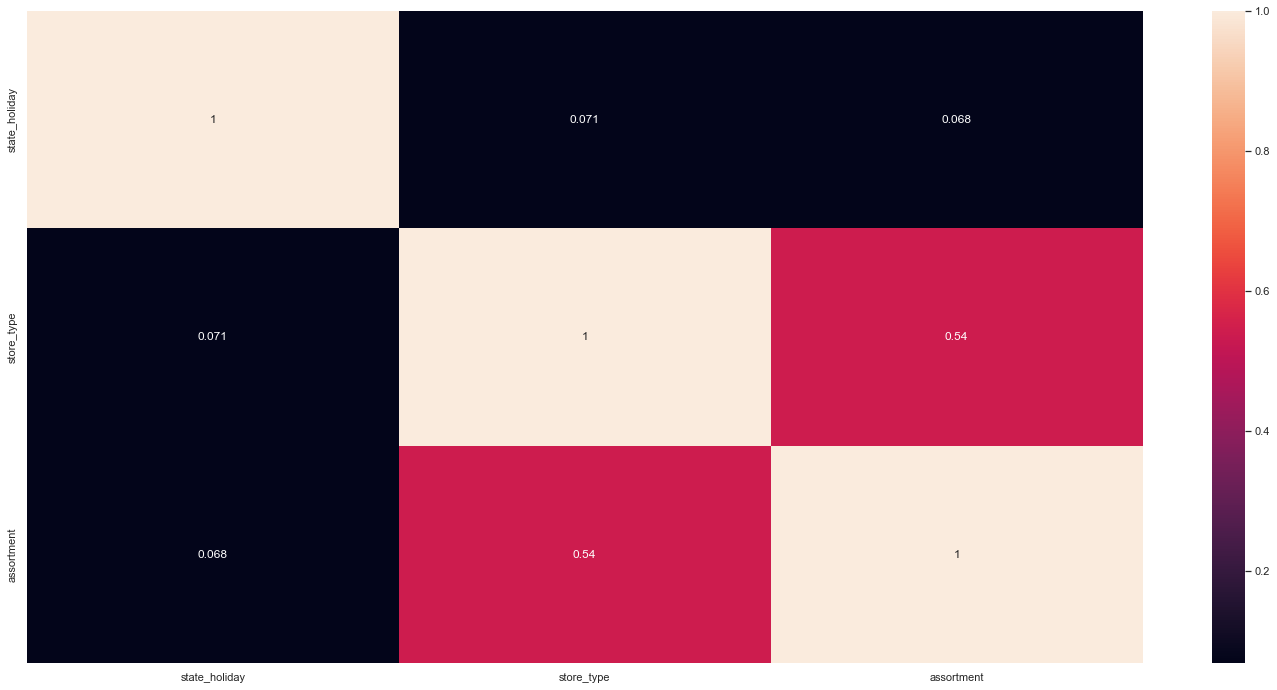

In [92]:
#Only Categorical Data
a = df4.select_dtypes(include = 'object')

#Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d= pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]
              } )
d = d.set_index(d.columns)
sns.heatmap(d,annot = True)

O V de Cramer, diferente de Pearson, varia de 0 a 1, ou seja, não há correlação negativa. 

Aqui é possível ver que state_holiday é pouco correlacionado com store_type e assortment. Por outro lado, store_type é bem correlacionado com assortment. O que faz sentido, uma vez que quanto maior o tipo da loja, mais produtos posso ter.

# <p style="color:#FF0000">5.0 DATA PREPARATION</p>

Neste passo a ideia é modelar os dados para o treinamento dos algoritmos de ML.

A motivação para fazer a prepação dos dados é facilitar o aprendizado dos modelos. Os modelos desempenham melhor com dados numéricos e na mesma escala, que é o que faremos aqui.

A maioria dos modelos de ML foram criados seguindo alguns critérios, um deles é que a variável seja numérica. Os principais modelos de ML trabalham com métodos de otimização e, a partir disso, eles encontram os melhores parâmetros para o seu conjunto de dados usando principalmente de derivadas, que são feitas em cima de variáveis numéricas (assim como as outras operações matemáticas). Será necessário então fazer a conversão das variáveis categóricas em numéricas. Esse método é chamado de encoding. 

Outro problema que encontrado é a escala dos dados, observando a tabela criada na etapa de descrição dos dados (seção 1.7.1), o range dos dados, ou seja, a diferença do mínimo pro máximo, varia muito. Dados, como day_of_week, tem uma variação de 6, enquanto a competition_distance tem uma variação de quase 200 mil. O problema neste caso é que as derivadas, utilizadas na criação do modelo, tendem a favorecer as variáveis que tem um maior range, tornando o modelo enviesado. Para resolver isso, é necessário normalizar as variáveis para que o modelo entenda todas as variáveis como iguais.

Será necessário fazer três tipos de preparação dos dados: a normalização, a rescaling e a transformação. A normalização é responsável por reescalar o centro para 0 e o desvio padrão para 1 e funciona bem para distribuições normais. A rescaling é semelhante, porém é feito uma reescala de 0 até 1 e é usado em distribuições não-gaussianas (que não tem uma distribuição normal). A transformação é dividida em dois tipo: A encoding, que transforma features categóricas para numéricas e a transformação de natureza. Um exemplo de transformação de natureza são os meses de um ano, ela é uma variável cíclica, ela vai de 1 até 12, depois volta para 1 e começa novamente até o 12, se repetindo cíclicamente. É preciso fazer uma transformação de forma que o modelo compreenda essa ciclicidade da feature.

Será resolvido cada tipo de preparação dos dados separadamente em seções.

In [93]:
df5 = df4.copy()

## <p style="color:#FF0000">5.1 Normalização</p>

A normalização é calculada da seguinte forma

$X_{new} = \frac{X_i - \mu}{\sigma}$

onde 

$\mu = $ média

$\sigma = $ desvio padrão.

Para fazer isso computacionalmente calcula-se a média da coluna e o desvio padrão. Depois disso, é selecionado o primeiro valor, subtrai da média e divide pelo desvio padrão. Repete isso para cada valor e assim terá variável normalizada.

um guia um pouco mais detalhado sobre o assunto pode ser encontrado em: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

Se você observar, a figura das distribuições de densidade originais nos mostra como são as curvas originais. Após a aplicação da normalização, as curvas que eram gaussianas foram para o centro, ficando em torno de zero. As outras você pode observar uma mudança na natureza da curva. Vale salientar que isso não vai afetar o seu modelo trazendo um resultado errado, porém, a performance do seu modelo será menor do que quando a normalização é feita em distribuições normais. 

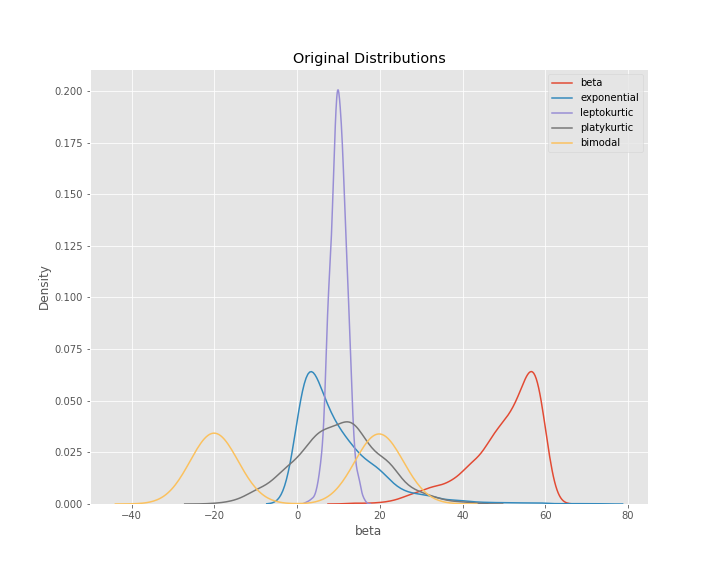

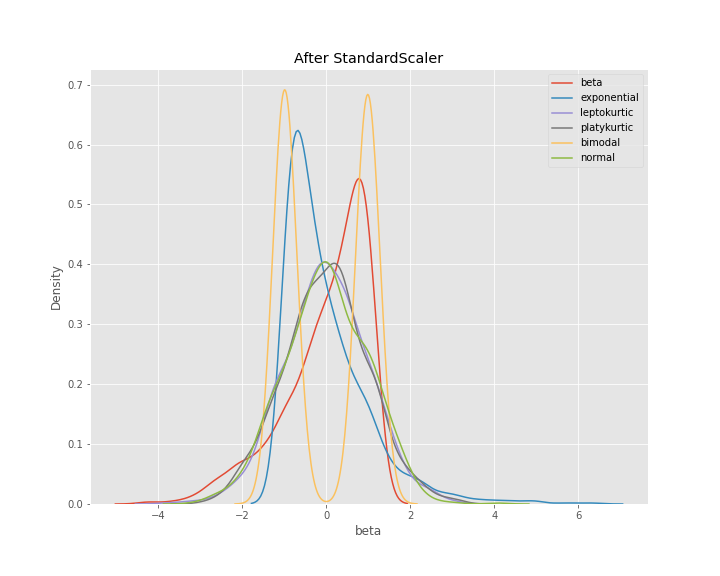

In [94]:
x = Image('../img/original_distributions.png')
y = Image('../img/after_standardscaler.png')
display(x, y)

Observando a seção 4.1.2 podemos ver que não temos nenhuma variável com uma distribuição normal (gaussiana), logo, este tipo de transformação não é útil para o nosso caso.

## <p style="color:#FF0000">5.2 Rescaling</p>

Vamos aprender algumas técnicas de rescaling, começando com a Min-Max Scaler, que é calculado da seguinte maneira:

$ X_{new} = \frac{X_i - \mu}{x_{max} - x_{min}} $ 

onde

$\mu = $ média.

Utilizando a mesma fonte mostrada anteriormente (em 5.1), o autor fez o comparativo da distribuição original com a reescalada a partir do min-max scaler. É possível observar que o formato das distribuição não se altera, entretanto, o range é alterado. Em outras palavras, não há uma alteração na natureza desta feature ao aplicar o Min-Max Scaler.

Um defeito da min-max scaler é que ela é muito sensível para outliers, isto vem da forma como ela é calculada. Se $x_{max}$ for muito grande, ou seja, um outlier, $X_{new}$ cai muito, podendo até se aproximar de zero. Consequentemente, é perdido um pouco o formato da distribuição, uma vez que seus dados estão muito próximos de zero. 

Para resolver isso, em vez de calcular pelo valor máximo, pode-se usar o intervalor inter-quartil, selecionando o terceiro quartil menos o primeiro quartil. Esta técnica é conhecida como Robust Scaler, que pode ser calculada por:

$ X_{new} = \frac{X_i - Q_1(x)}{Q_3(x) - Q_1(x)} $

onde

$Q_1(x) = $ 1º quartil
$Q_3(x) = $ 3º quartil

Assim, o problema de outlier da feature é resolvido. A diferença do Min-Max Scaler para o Robust Scaler é que ele coloca os dados um pouco mais juntos, muito pela questão dos outliers. 

Em resumo, uma solução que (quase) sempre vai funcionar é aplicar o Min-Max Scaler em features sem outliers significativos e aplicar o Robust Scaler para features com muitos outliers.

In [95]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [96]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31


In [97]:
# competition_distance
# year
# competition_time_month
# promo_time_week

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

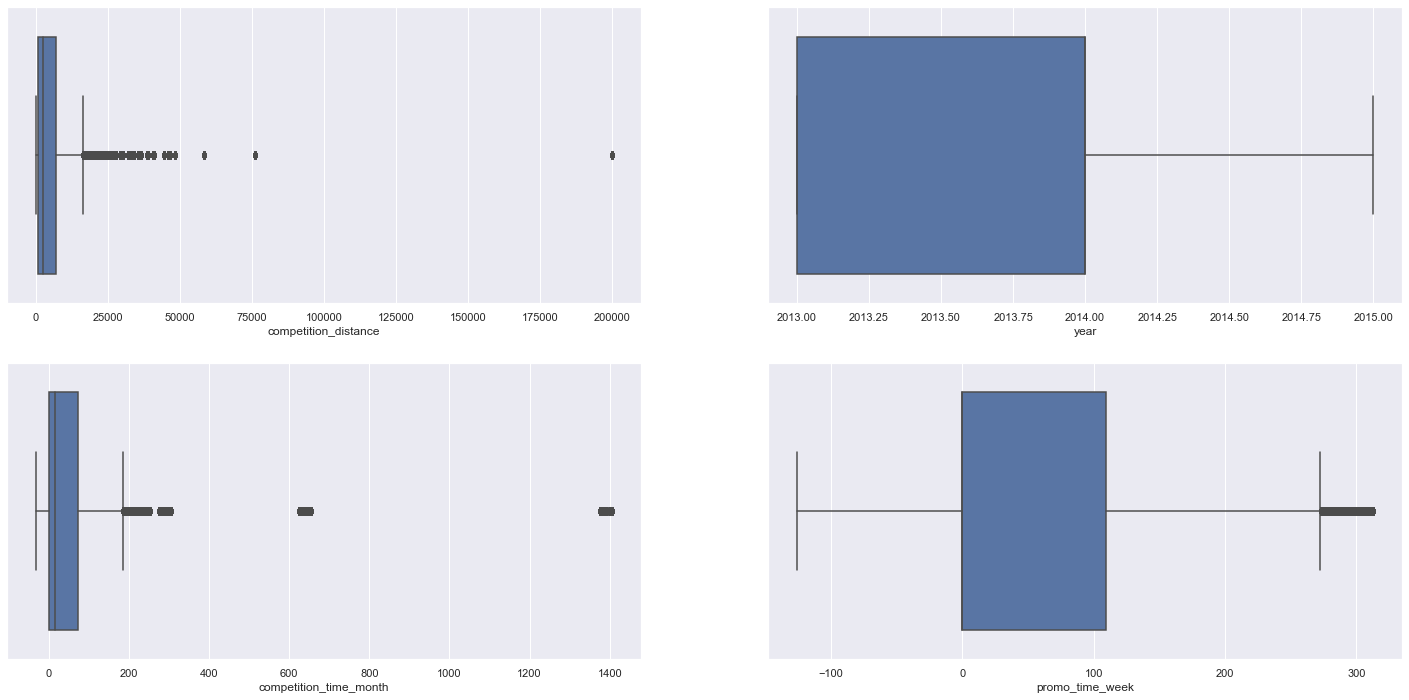

In [98]:
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']);

plt.subplot(2,2,2)
sns.boxplot(df5['year']);

plt.subplot(2,2,3)
sns.boxplot(df5['competition_time_month']);

plt.subplot(2,2,4)
sns.boxplot(df5['promo_time_week']);

É possível ver que competition_distance e competition_time_month tem outliers muito grandes, de forma que a melhor solução para reescalá-los é utilizando o Robust Scaler. Year e promo_time_week será utilizado o min-max scaler. Vale salientar que promo_time_week tem outliers, entretanto, seus outliers são muito próximos de Q3, de forma que não atrapalhe o funcionamento do min-max scaler.

In [99]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [100]:
rs = RobustScaler()
mms = MinMaxScaler()
#Competition_Distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )
pickle.dump(rs,open('../parameter/competition_distance_scaler.pkl','wb'))
# A fit_transform encontra os parâmetro da formula e já aplica nos dados. Os parâmetros são os mostrados anteriormente.
# Pode ser usado também a "fit", entretanto, seria necessário calcular manualmente os parâmetros e o fit aplicaria.

#Competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs,open('../parameter/competition_time_month_scaler.pkl','wb'))

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms,open('../parameter/promo_time_week_scaler.pkl','wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('../parameter/year_scaler.pkl','wb'))

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


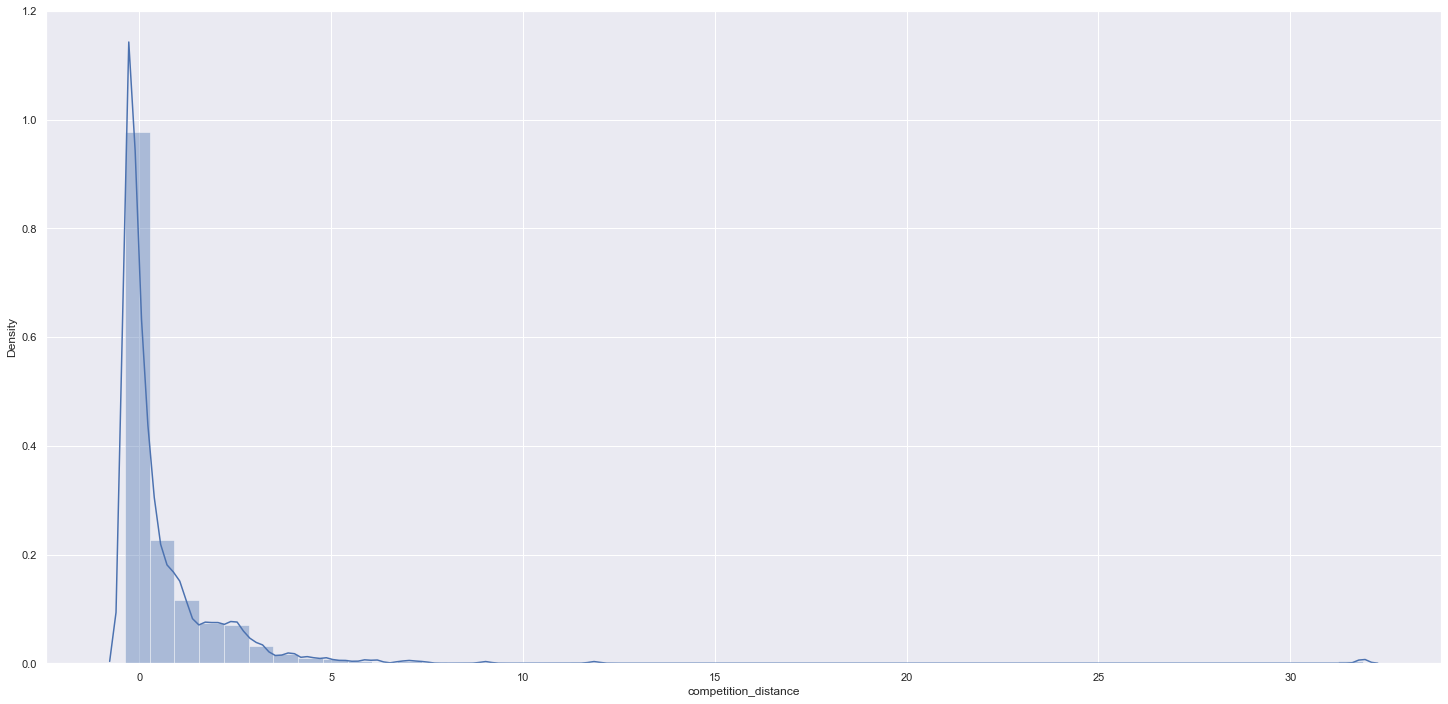

In [101]:
sns.distplot(df5['competition_distance']);

É possível observar que os valores foram reescalados para ficarem entre 0 e 1.

## <p style="color:#FF0000">5.3 Transformação</p>

### <p style="color:#FF0000">5.3.1 Encoding</p>

Existem vários tipos de encoding, para decidir qual a melhor para a sua feature é necessário testar, não há uma solução mágica, precisa-se testar. Aqui vai ser focar em apenas alguns tipos.

O primeiro é o One Hot Encoding (ou Dummy Encode), neste caso, é feito a separação, cada nível é transformado em uma coluna de 0 ou 1. Um exemplo prático pode ser encontrado na referência. A vantagem deste modelo é que ele é fácil e rápido de aplicar, a desvantagem é que ele cria muitas novas colunas no dataset, aumentando a dimensionalidade do seu modelo, o que pode gerar um overfit. Ou seja, este tipo de encoding só é interessante quando não se tem muitos níveis categóricos. Por exemplo, uma boa aplicação é em caso de feriados ou não, não haverá um grande aumento na dimensionalidade, assim, o OHE funciona bem.

O segundo é o Label Encoding, onde há a troca dos níveis da variável por números, por exemplo, tem-se uma variável com temperatura: Hot, Cold, Very Hot, Hot, Cold. Usando o Label Encoding ficará: 1,2,3,1,2. Ou seja, sempre que aparece "Hot" vira "1" e assim por diante. Não tem necessariamente uma relação de grandeza. Este tipo de encoding funciona muito bem quando não há uma relação explicita.

O terceiro é o Ordinal Encoding, funciona muito parecido com o Label, entretanto, a única diferença é que é preciso respeitar uma ordem. Usando o mesmo exemplo da temperatura, cold seria 1, enquanto very hot seria 4. A ordem seria cold = 1, warm = 2, hot = 3 e very hot = 4. Conforme a temperatura aumenta, o número aumenta também. Este tipo de encoding vai funcionar para caso sua variável tenha uma hierarquia, caso não tenha, não é recomendado a aplicação deste tipo de encoding. 

Existe uma lista com mais encoding e explicações em: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

Além desses, tem uma lista de pacotes em: https://contrib.scikit-learn.org/category_encoders/

Aqui será usado a OHE, label encoding e ordinal encoding.

In [102]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [103]:
#state_holiday - One Hot Encoding
# Como são poucos niveis, podemos usar o OHE
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
# Não se sabe a ordem se a > b > c, por isso, foi decidido só trocar letras por numeros
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le,open('../parameter/store_type_scaler.pkl','wb'))

#assortment  - Ordinal Encoding
# Considera-se basic < extra < extended, assim, basic será = 1, extra = 2 e extended = 3.
assortment_dict = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [104]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### <p style="color:#FF0000">5.3.2 Response Variable Transformation</p>

Existem dois tipos de transformações, a de grandeza e a de natureza. A de grandeza é importante para tentar aproximar a variável resposta o mais próximo possível da normal. A de natureza, o objetivo é trazer a natureza real dos seus dados dentro do conjunto de dados. 

A transformação de grandeza é importante devido ao fato dos algoritmos de ML terem sido criados em cima de algumas premissas, uma delas é que seus dados sejam normalmente distribuídos. Quanto mais próximo a sua variável estiver das premissas, maior a sua acurácia. Por isso é importante transformar a sua variável resposta em uma distribuição normal. 

A transformação de natureza, como dito anteriormente, é quando temos variáveis cíclicas. Aqui, é necessário fazer uma transformação, por exemplo, para que o modelo entenda que o mês 12 é próximo ao mês 1 (do ano posterior). 

Um tipo de transformação possível é a transformação logarítmica. Ela transforma variáveis com skew muito a esquerda ou a direita o mais próximo possível de uma normal. Outro tipo de transformação é a Box-Cox transformation tem uma fórmula que já está implementada em python. Tem a transformação Cube-Root, que é extrair a raiz cubica de todos os valores. A square-root que é a raiz quadrada. A transformação seno e cosseno, que transforma, como o nome já diz, em senos e cossenos.

In [105]:
df5['sales'] = np.log1p(df5['sales'])

C:\Users\ASPIREB E15\anaconda3\envs\RosmannStoreSales\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

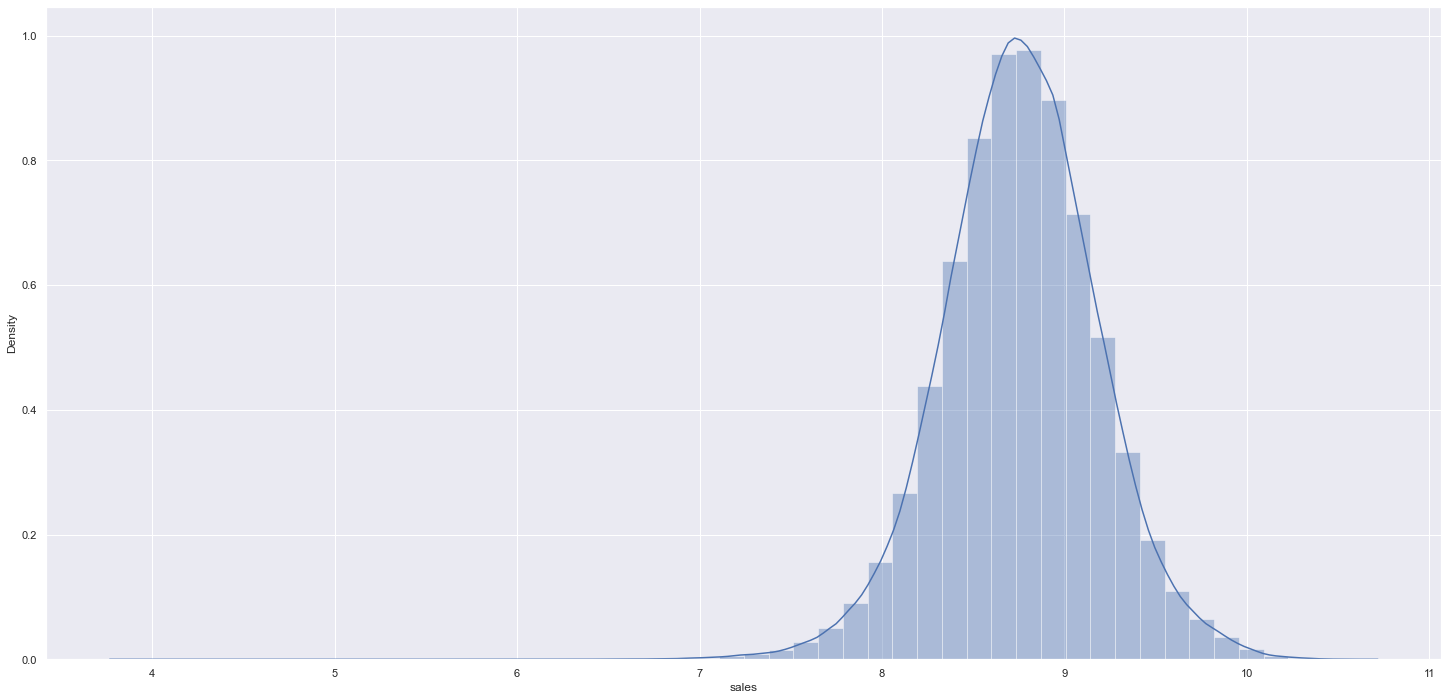

In [106]:
sns.distplot(df5['sales'])

### <p style="color:#FF0000">5.3.3 Nature Transformation</p>

É preciso representar a natureza cíclica das variáveis. Primeiro, é necessário levar em conta a distância de uma pra outra, neste caso, a distância seria igual. A distância de Janeiro para Dezembro ou para Fevereiro são as mesmas, que é de 1 mês. Para representar isso, considere o círculo trigonométrico, como na figura abaixo. Em vez dos valores de $\pi$, imagine os meses. A partir da distância entre o centro até $\pi/3$, existe um certo ângulo, para $\pi/4$, outro ângulo, a partir desse ângulo, é possível calcular o seno e o cosseno, transformando assim sua variável em duas, uma referente ao seno e outra ao cosseno. 

referencia: https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

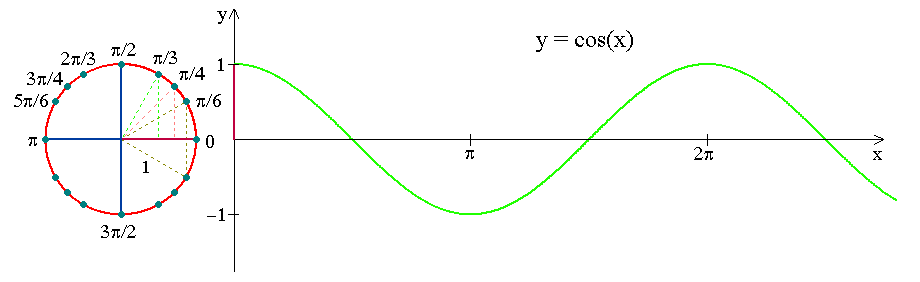

In [107]:
Image('../img/nature.gif')

In [108]:
# month
# Considera aqui o seno(2*pi/divisão), podendo a divisão ser os meses (12). ou os dias (30) - em media. semanas do ano (52), por aí vai. 
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [109]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# <p style="color:#FF0000">6.0 FEATURE SELECTION</p>

## Motivação

Vamos agora selecionar as variáveis mais relevantes para o modelo. Será necessário fazer uma seleção de variáveis de forma que o modelo seja mais simples possível. Esta simplicidade vem da quantidade de colunas que o modelo receberá. Não é viável para o modelo colocarmos uma quantidade gigante de features, apenas as que são realmente indispensáveis. Features que representam, por exemplo, a mesma parte fenômeno, podem ser excluídas da seleção. Estas variáveis são conhecidas como variáveis colineares.

É preciso entender como os métodos classificam as variáveis como relevantes ou não relevantes para o modelo. Além disso, é necessário compreender as vantagens e desvantagens de cada método. Como aqui será usado o algoritmo Boruta, a explicação será dada apenas deste algoritmo. Explicações complementares podem ser encontradas em: https://github.com/CaioMendes92/RossmannStoreSales/blob/main/notebooks/store_sales_prediction_estudo.ipynb
ou nas referencias abaixo.

O método é chamado de seleção por SubSet (Wrapper Methods), aqui, tem-se uma sequência de passos para determinar a relevância da variável. O primeiro passo é selecionar aleatoriamente uma única variável. Com esta variável + variável resposta, treina-se um modelo de ML, em geral uma random forest ou uma gxboost. Após o treino realizado, é calculado a performance do modelo, que pode ser em termos de acurácia ou de erro. Assumindo que foi encontrado uma acurácia de 62%, o próximo passo é comparar com a performance anterior e ver se houve um aumento de acurácia. Na primeira interação não existia uma baseline de comparação, logo, será o valor de 62% considerado a baseline. Repete o processo, selecionando uma nova variável aleatoriamente e adiciona ao seu novo conjunto de dados, tendo agora 2 variáveis e 1 variável resposta. Faz o treino novamente e calcula novamente a performance, por exemplo, chegando a 65%. Caso a performance tenha aumentado, mantém a variável e adiciona mais uma aleatoriamente. Retreina o modelo e calcula novamente a performance do modelo. Caso a performance seja menor ou igual a vez anterior, remove-se a variável e seleciona outra aleatoriamente. Depois de várias repetições desse ciclo, têm-se um subset com as variáveis mais relevantes. Existe um algoritmo que já faz isto, é o chamado Boruta, que é o que será usado neste projeto.

O Boruta seleciona no seu conjunto de dados original duas variáveis aleatórias, após isso, cria o que é chamado de variáveis shadow, que é uma cópia da variável original com as linhas embaralhadas. Este embaralhamento é feito para remover a correlação entre as variáveis, pois caso seja feito apenas a cópia elas a correlação será máxima, afinal é uma cópia. Então, saímos de um conjunto de 2 variáveis para um conjunto com 4 variáveis. Com essas 4 variáveis o modelo é treinado por uma random forest. Depois, encontra-se a importância de cada uma dessas features, tanto as originais quanto as shadow. O próximo passo do boruta é comparar as duas variáveis shadow para ver qual é a mais importante e então comparar a importância de cada uma das variáveis originais com a variável shadow selecionada. Cria-se uma tabela que será preenchida com 1 ou 0, caso a importância da variável original seja maior que a shadow, preenche com 1, caso não, com 0. Repetindo isso para cada linha da variável original, tem-se uma tabela chamada de success counts. Com essa tabela é possível calcular o p-valor a partir dessa distribuição binomial. O p-valor irá validar se uma hipótese é aceita ou rejeitada, aqui serve para determinar se uma variável é importante ou não. Isto é feito a partir do gráfico da distribuição binomial e define-se um limite do p-valor. Se o p-valor da variável for menor que o p-valor limite, confirma a variável como importante, caso contrário, rejeita-se. Estes passos são repetidos várias vezes até o boruta passar por todas as variáveis e chegar em um dataset reduzido.

Um exemplo com imagens mais claro sobre o boruta pode ser encontrado em: https://medium.com/data-hackers/como-selecionar-melhores-vari%C3%A1veis-para-o-seu-modelo-com-boruta-ef7cbfb3fc35

Uma explicação mais detalhada sobre feature selection pode ser encontrada em: https://dev.to/charfaouiyounes/hands-on-with-feature-selection-techniques-an-introduction-127k

Filter: https://medium.com/analytics-vidhya/feature-selection-for-dimensionality-reduction-filter-method-201cc9eaa3b5

Embedded: https://medium.com/analytics-vidhya/feature-selection-for-dimensionality-reduction-embedded-method-e05c74014aa

Wrapper: https://medium.com/analytics-vidhya/feature-selection-for-dimensionality-reduction-wrapper-method-9979fffd0166

## Copy

In [110]:
df6 = df5.copy()

## <p style="color:#FF0000">6.1 Split dataframe into training and test dataset</p>

In [111]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


Será necessário deletar algumas variáveis, por exemplo, week_of_year, que foi transformada em week_of_year_sin e week_of_year_cos. O mesmo para day, month e day_of week. O promo_time_week foi gerada a partir do promo_since, então, precisamos deletar promo_since, o mesmo vale para competition_since e year_week. 

In [112]:
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1 )

Como o problema aqui leva em consideração o tempo, a divisão de treino e teste deve levar em conta isto também. Não é possível selecionar aleatoriamente as linhas que pertence ao teste/treino, pois estaria sendo feito uma mistura do passado e futuro, se o modelo já sabe o futuro ele acertaria praticamente 100%. Como as vendas são por dia, é feito uma separação das últimas 6 semanas como teste e os outros dados como treino. 

In [113]:
df6[['store', 'date']].groupby('store').min().reset_index().head()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02


In [114]:
df6[['store', 'date']].groupby('store').max().reset_index().head()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31


É possível observar que os dados começam em 02-01-2013 e vão até 31-07-2015, é necessário então pegar a data 6 semanas antes. 

In [115]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [116]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

Então, o conjunto de dados termina em 19-06-2015.

In [117]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Teste Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Teste Max Date: 2015-07-31 00:00:00


## <p style="color:#FF0000">6.2 Boruta as Feature Selector</p>

In [118]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [119]:
#training and test for boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor (n_jobs = -1)

#n_jobs = -1 ele rodará todos os processos em paralelo ao mesmo tempo. 

#boruta = BorutaPy(rf, n_estimators='auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)    # Demora 2h 30min para rodar.

# rf indica que estamos usando a random forest, n_estimators indica para o boruta que ele selecionará automaticamente a quantidade de estimadores,
# verbose indica que ele irá printar na tela para sabermos se ele ainda está rodando.
# random_state é o seed, para ele partir do mesmo ponto aleatório sempre, caso precisemos rodar novamente o algoritmo.

### <p style="color:#FF0000">6.2.1 Best Features from Boruta</p>

Devido ao fato do Boruta demorar muito, para o processo ser mais rápido, o algoritmo foi rodado uma vez, as colunas selecionadas e foi criado uma lista com elas, para não precisar rodar novamente.

In [120]:
#cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list() 
cols_selected_boruta = ['store',  'promo', 'store_type', 'assortment',  'competition_distance', 'competition_open_since_month',  
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                        'promo_time_week', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
                            'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']

In [121]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [122]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

Compara-se agora as features do boruta com as features que foram encontradas na EDA. Na seção 4.2.1 encontra-se o resumo das hipóteses. Nas análises, o ano foi uma variável que foi considerado importante, enquanto o Boruta descartou. A decisão é pessoal se adiciona ou não a variável, uma sugestão é usar as sugestões do Boruta inicialmente e depois adicionar as outras variáveis e testar. Pelo fato de apenas uma feature foi descartada pelo Boruta em relação a EDA é sinal que a análise na seção 4 foi bem feita.

## <p style="color:#FF0000">6.3 Manual Feature Selection</p>

In [123]:
cols_selected_boruta = ['store',  'promo', 'store_type', 'assortment',  'competition_distance', 
                        'competition_open_since_month',  'competition_open_since_year', 'promo2', 
                        'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                        'promo_time_week', 'month_sin','month_cos', 'day_sin', 'day_cos', 'week_of_year_sin','week_of_year_cos',
                        'day_of_week_sin', 'day_of_week_cos']

feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [124]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# <p style="color:#FF0000">7. Machine Learning Modeling</p>

## Motivação

Um modelo de ML é um algoritmo que é capaz de aprender um comportamento de um fenômeno a partir dos dados disponíveis no dataset e depois generalizar este aprendizado para outros exemplos.

Os tipos de algoritmos de ML podem ser divididos em três grandes grupos: Supervisionado, Não-supervisionado e semi-supervisionado. No caso de algoritmos subervisionados, o algoritmo recebe um parâmetro de resposta e as features, pra então, prever novas respostas baseadas nas features e respostas anteriores. Ele faz um comparativo do que ele aprendeu. Um modelo supervisionado pode ser de classificação, regressão ou previsão. No caso de classificação, o modelo vai classificar algo, dizer se um e-mail é um spam ou não é um exemplo, se a compra em um cartão de crédito é valido ou uma fraude, classificar um animal como cachorro ou gato, entre outros. Um modelo de regressão é, por exemplo, vendas. O modelo recebe algumas features, como o tamanho da loja, dias de funcionamento, local, entre outros. Junto a isso ele recebe o quanto as lojas venderam e então, passando as features de uma outra loja, pede para o modelo prever quanto a loja irá vender. Além destes casos, temos também um problema de previsão, que leva em conta uma variável temporal, como é o caso do nosso problema aqui. O modelo aprende, usando as features que temos, como são as vendas dia-a-dia, depois pede para o modelo prever como serão as vendas no futuro. 

Vamos agora implemenar alguns modelos de machine learning, todos supervisionados e do tipo previsão. Vamos começar pelo Average Model, que basicamente é uma média, o modelo recebe os dados de entrada e retorna a média. Dada uma loja X, o modelo retorna a média de vendas desta loja. Vale salientar que a função de um modelo de médias é servir de base comparativa para os outros modelos, ou seja, servirá de baseline. 

O segundo modelo que será implementado é a Linear Regression e o terceiro é o Linear Regression Regularized, também conhecido como Lasso. Ele tem um parâmetro a mais que a Linear Regression e em geral performa um pouco melhor. Vale salientar que os dois são modelos lineares, se o resultado encontrado aqui for satisfatório, podemos indicar que nossos dados tem um comportamento linear. Caso isso não ocorra, aí sim faz-se necessário partir para uma abordagem usando modelos não lineares e mais complexos.

Partindo para modelos não lineares, o quarto modelo aplicado será uma Random Forest Regressor e a quinta uma XGBoost Regressor, os dois são modelos em árvores que foram adaptadas para regressões, uma vez que no início eram usadas como classificações. A diferença entre as duas é que a XGBoost usa um método chamado Bagging e Boosting, para selecionar os métodos mais rápido e mais relevantes.

## Separando o dataset em treino e teste

In [125]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
 
#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

In [126]:
x_train.dtypes

store                             int64
promo                             int64
store_type                        int32
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month          float64
promo_time_week                 float64
month_sin                       float64
month_cos                       float64
day_sin                         float64
day_cos                         float64
week_of_year_sin                float64
week_of_year_cos                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
dtype: object

## <p style="color:#FF0000">7.1 Average Model<p>

In [127]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [128]:
#def mean_absolute_percentage_error(y, yhat):
#    return np.mean(np.abs( (y - yhat)/y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

In [129]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

#preformance
baseline_result = ml_error('Average_Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result 
# É possível observar que tem uma exponencial em y_test, isso se dá pois no momento do treino do modelo foi feito aplicado um log em 5.3.2.

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.2064,1835.135542


## <p style="color:#FF0000">7.2 Linear Regression Model</p>

In [130]:
from sklearn.linear_model import LinearRegression, Lasso

In [131]:
#Model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


Comparando o RMSE do linear regression model com o do Average Model, vemos que o erro do modelo linear é maior que a média, ou seja, a média é um resultado melhor que um modelo de ML. Isto se dá devido ao fato do nosso modelo ser não-linear, assim, um modelo linear encontra um erro muito grande.

### <p style="color:#FF0000">7.2.1 Linear Regression Model - CrossValidation</p>

Será necessário fazer uma crossvalidation para todos os modelos. Isto é importante para diminuir a chance de termos um validação que não condiz com a realidade do que aconteceu com os nossos dados. Por exemplo, se o modelo aprendeu com uma parte dos dados que tem um comportamento mais regular e fácil de entender, nossa performance será muito alta, entretanto, isso não condiz com a realidade. Precisamos dividir nosso dataset em várias partes e que o modelo treine/valide com todas elas, aí sim teremos uma métrica mais real do que aconteceu.

A Crossvalidation pode ser aplicada em regressão, classificação ou uma time series. Para melhor compreender a crossvalidation, divida o dataset em 10 partes. A parte 1 é selecionada para validação, enquanto as outras 9 para treino. Depois uma outra parte é selecionada para validação, enquanto as outras partes para treino, assim por diante. Após isso, é feito a média destes dez erros e esse será o resultado real do nosso modelo. O erro é calculado pela média mais ou menos o desvio padrão. Ou seja: $Performance Real = MEAN(Erro_1,Erro_2,...,Erro_N) \pm STD(Erro_1,Erro_n,...,Erro_N)$.

Esta é a crossvalidation para regressão ou classificação, entretanto, para uma time series é necessário um procedimento um pouco diferente, uma vez que o tempo é levado em consideração. Essa separação não pode ser feita de qualquer jeito, a ordem cronológica dos dados devem ser respeitadas. Imagine novamente o exemplo anterior. Agora, em vez de selecionado 1 parte para validação a cada passo, nós pegamos uma parte para treino e uma parte para validação, ou seja, a parte 1 é para treino, a parte 2 para validação. No próximo passo, o treino é feito sob a parte 1 e 2, enquanto a validação sob a parte 3. Em seguida o treino é realizado com a parte 1,2 e 3 e a validação com a parte 4, assim por diante. 

In [132]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


Comparando RMSE com RMSE_CV é possível ver que os valores são diferentes, o erro sem o crossvalidation é menor, o que induziria a uma tomada de decisão errada.

## <p style="color:#FF0000">7.3 Linear Regression Regularized Model</p>

In [133]:
#Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### <p style="color:#FF0000">7.3.1 Lasso - CrossValidation</p>

In [134]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## <p style="color:#FF0000">7.4 Random Forest Regressor</p>

In [135]:
from sklearn.ensemble import RandomForestRegressor

In [136]:
#Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837


### <p style="color:#FF0000">7.4.1 Random Forest Regressor - CrossValidation</p>

In [137]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73


## <p style="color:#FF0000">7.5 XGBoost Regressor</p>

In [138]:
import xgboost as xgb

In [145]:
#Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 300,
                             eta = 0.03,
                             max_depth = 5,
                             subsample = 0.7,
                             colsample_bytree = 0.7,
                             min_child_weight = 3).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1528.390215,0.229317,2205.109789


### <p style="color:#FF0000">7.5.1 XGBoost Regressor - CrossValidation</p>

In [146]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,1662.07 +/- 188.71,0.23 +/- 0.01,2396.14 +/- 260.05


## <p style="color:#FF0000">7.6 Compare Model's Performance</p>

### <p style="color:#FF0000">7.6.1 Single Performance</p>

In [147]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837
0,Average_Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1528.390215,0.229317,2205.109789
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


É possível ver que será necessário usar modelos não-lineares. Mesmo a RF tendo o melhor resultado, aqui, será utilizado o modelo XGBoost. A princípio pode causar uma estranheza o modelo escolhido ser o que performou pior, porém, vale salientar que uma RF consome muito mais capacidade computacional que qualquer outro modelo, de forma que vale o risco de fazer os ajustes finos de uma XGBoost e observar como ela se comporta. É importante lembrar que está sendo utilizado o método CRIPS-DS, então, caso não seja encontrado um resultado satisfatório, em um próximo cíclo será utilizado o modelo de RF.

### <p style="color:#FF0000">7.6.2 Real Performance - CrossValidation</p>

In [148]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE_CV')

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73
0,XGBoost Regressor,1662.07 +/- 188.71,0.23 +/- 0.01,2396.14 +/- 260.05
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# <p style="color:#FF0000">8. HyperParameter Fine tuning</p>

## Motivação

Hyper Parameter em ML são todos os parâmetros que o modelo usa para aprender o comportamento. Em uma Random Forest o hyper parameter são os numeros de estimadores, o max deph, quantidade de nós, eta, entre outras. O processo de fine tuning tem como objetivo encontrar os melhores parâmetros que maximiza o aprendizado do modelo. 

Existem algumas estratégias para realizar o fine tuning, aqui vamos focar na random search. A random search, como o nome já diz, ele define aleatoriamente os valores de cada hyperparameter é testa. É definido uma lista com os valores dos hyper parameters e o random search faz as combinações aleatoriamente. A quantidade de valores que cada parâmetro pode assumir é arbitrário e decidido por você, o que o random search faz é realizar combinações aleatórias a partir dos parâmetros decididos por você. Você define quantas vezes o random search fará as combinações, depois disso você treina/testa seu modelo e guarda o resultado baseado nesses hyperparameters. A vantagem do random search é que ele é mais rápido que as outras técnicas e fácil de implementar. Entretanto, a desvantagem é que, devido a pesquisa ser aleatória você pode acabar selecionando o mesmo conjunto de valores que você testou em outra interação, então, você perderia uma interação, o que é perca de tempo. Porém, a maior desvantagem é o fato de que você pode nunca conseguir encontrar o melhor conjunto de valores que maxima o resultado do modelo. 

Aqui, vamos seguir com o random search no XGBoost, pois ele é mais rápido e podemos voltar para outros testes em outros ciclos do CRISP.

Referencias para bayesian search: https://github.com/fmfn/BayesianOptimization

Referencias para grid search: https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27

Referencias para random search: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

Referencias para fine tuning: https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d

## <p style="color:#FF0000">8.1 Random Search</p>

In [243]:
import random
import warnings
warnings.filterwarnings('ignore')

In [244]:
param = {
    'n_estimators': [1500,1700,2500,3000,3500],
    'eta': [0.01,0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 10

In [245]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    # Choose values for parameters randomly
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)
    
#    #Model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'])

#    #performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose = False)
#    final_result = pd.concat([final_result,result])
#final_result

# Demora 1 dia para rodar

O snippet acima foi comentado por demora mais de 1 dia para rodar, os parâmetros encontrados por ele foram salvos na seção 8.2 logo abaixo.

## <p style="color:#FF0000">8.2 Final Model</p>

In [246]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }

In [247]:
#Model
model_xgb_tunned = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = param_tuned['n_estimators'],
                             eta = param_tuned['eta'],
                             max_depth = param_tuned['max_depth'],
                             subsample = param_tuned['subsample'],
                             colsample_bytree = param_tuned['colsample_bytree'],
                             min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#Prediction
yhat_xgb_tunned = model_xgb_tunned.predict(x_test)

#performance
xgb_result_tunned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tunned))
xgb_result_tunned

# 1h 10m para rodar.

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,773.436567,0.116557,1105.32702


Podemos observar uma queda significativa dos erros aqui em comparação aos passos anteriores. Na próxima seção será explicado em mais detalhes o que cada erro significa.

# <p style="color:#FF0000">9. Interpretação e tradução de erro</p>

## Motivação/Explicação

Precisamos entender os erros e então conseguir traduzir estes erros em negócio, entender quanto será ganho ou perdido pela empresa em valores, não apenas em métricas ou porcentagens. Vamos dividir esse processo em duas partes, a primeira é entender a performance de um modelo de regressão, entender o que é uma MAE (mean absolute error), MAPE (Mean Absolute Percentage Error), RMSE (Root Mean Squared Error) e MPE(Mean Percentage Error). 

O erro MAE consiste em calcular a diferença entre o valor real e o valor que o modelo previu para todos os valores e dividir pelo número total de valores, ou seja, fazer a média da diferença entre o real e o previsto. Quanto mais próximo de zero este erro, mais preciso seu modelo foi. Em linguagem matemática: $MAE = \frac{1}{N}\sum |Y-Y_{hat}|$, onde $Y$ é o valor real, $Y_{hat}$ o valor previsto pelo modelo e $N$ o número total de pontos. Uma das características do MAE é que ele atribui pesos iguais para todos os erros, isto pode ser problemático, por exemplo, em casos de outliers. Se o seu erro é muito grande por causa de um outlier você não consegue ter esta noção, pois o valor é diluído entre todos os outros pontos. Um ponto positivo é que ele é fácil do time de negócio entender. Para entender se o valor encontrado é alto ou baixo, ou seja, se o seu modelo trouxe um resultado satisfatório, precisa-se comparar com o range da sua variável. Por exemplo o XGBoost deu em torno de 600 o erro, ou seja, a venda pode variar em até 600 do valor previsto pelo modelo. Se estiver sendo falado de vendas na ordem 1MM, 600 não é um erro grande, porém, se fala-se da ordem de 1k, 600 é um erro bastante relevante. Assim, o tamanho da variável é importante para classificar se o erro é grande ou não. Observando o fim da seção anterior, vemos que o range é de 41k, ou seja, 600 a mais ou a menos não influencia tanto o resultado, de forma que pode-se considerar nosso modelo com uma boa precisão. Porém, além disso, deve ser levar em conta a média de vendas, assim, o resultado será ainda mais preciso. Ainda na seção anterior, é possível ver que o erro percentual em cima da média é de 11%, este erro é o MAPE.

O erro MAPE é complementar ao erro MAE, matematicamente, em vez de apenas dividir sob o total de pontos, divide-se pelo valor real também, para assim ter uma noção da porcentagem do erro, ou seja, $MAPE = \frac{100\%}{N} \sum \frac{|Y-\hat{Y}|}{Y}$. Este erro tem a vantagem de mostrar o quão bom nosso erro está em relação a média e em porcentagem. Ele é ideal para apresentar resultados, entretanto, o MAPE não pode ser usado caso sua variável resposta conter 0, uma vez que é feito a divisão por $Y$. 

O erro RMSE, ao invés de usarmos o módulo, agora eleva-se a diferença do real e predito ao quadrado e depois tira sua raiz quadrada, matematicamente: $RMSE = \sqrt{\frac{1}{N}\sum \left(Y-\hat{Y}\right)^2}$. O RMSE, em geral, é usado para melhorar a performance do modelo de ML, uma vez que ele é mais sensível para outliers. Então, é indicado analisar o RMSE para realizar melhorias no modelo, mas reporta-se o MAE ou MAPE para o time de negócio. Vale salientar que, apesar do RMSE ter um valor mais alto que o MAE, esta diferença não é tão significativa a ponto de causar tantos questionamentos, entretanto, se o problema for um caso onde a precisão seja um fator chave, como o caso de um diagnóstico médico que o erro deve ser o menor possível, deve-se apresentar o RMSE. 

O erro MPE é importante para entender se o modelo está subestimando ou superestimando os valores. Ou seja, uma vez que temos os valores reais e os previstos, subtrai-se um do outro, divide-se pelo total e multiplica-se por 100%, ou seja, $MPE = \frac{100\%}{N}\sum\frac{Y-\hat{Y}}{Y}$. Vale salientar que o MPE não pode ser usado para medir a acurácia do modelo, uma vez que os erros estão sendo cancelados, ele tem a ver com a qualidade do modelo. Novamente, não deve haver valores reais com 0, uma vez que a divisão é feita por $Y$. É possível observar que o modelo aqui superestimando nossos dados. Na maioria dos erros o modelo aqui empregado fará a previsão para maior. 

A segunda parte é entender a performance do modelo sobre o negócio. Esta parte pode ser comparando com o Status quo, ou seja, entender a partir de como as pessoas estão fazendo hoje. Em geral usasse uma média ou uma média móvel, o que será feito é comparar o quanto isso trás de resultado com o quanto nosso modelo trás. A segunda forma é mostrar qual o incremento de receita que o modelo trás.

A comparação com o Status quo, toda loja tem uma previsão de receita, vendas, clientes, etc. Em geral, estas previsões são uma reta, se o comportamento das métricas se mantém lineares, o modelo acerta. Entretanto, o modelo de ML é interessante pois ele prevê inclusive as quedas e o crescimentos. Com estes dados, calcularia-se o MAE e o MAPE usando o modelo que já existe. Por exemplo, o MAE da empresa é de 1100 e o MAPE de 17%, comparado ao nosso MAE de 773, o que dá uma diferença de 327. Então, por regra de três, temos que a porcentagem do nosso MAE para o da empresa é de 29,72%, ou seja, nosso modelo é 29,72% mais preciso. A diferença do MAPE seria de 6%.

## .

In [250]:
mpe = mean_percentage_error(np.expm1(y_test),np.expm1(yhat_xgb_tunned))
mpe

-0.019006972667617486

In [251]:
df9 = X_test[cols_selected_boruta_full]

# Reescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tunned)

## <p style="color:#FF0000">9.1. Business Performance</p>

In [252]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()
#Calculo da previsao por loja

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: 
                                                                       mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})

df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: 
                                                                       mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner',on='store')
df92 = pd.merge(df91,df9_aux3,how='inner',on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario', 'best_scenario','MAE','MAPE']]

In [253]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,168335.796875,168023.734276,168647.859474,312.062599,0.071731
1,2,182637.468750,182198.770488,183076.167012,438.698262,0.088684
2,3,266961.718750,266315.069415,267608.368085,646.649335,0.088830
3,4,342521.093750,341655.951000,343386.236500,865.142750,0.082401
4,5,172209.421875,171814.970525,172603.873225,394.451350,0.088138


Então, temos o total de dinheiro que vai entrar por loja nas próximas 6 semanas, além disso, definimos qual o pior cenário possível e o melhor cenário, juntamente com os erros MAE e MAPE.

<AxesSubplot:xlabel='store', ylabel='MAPE'>

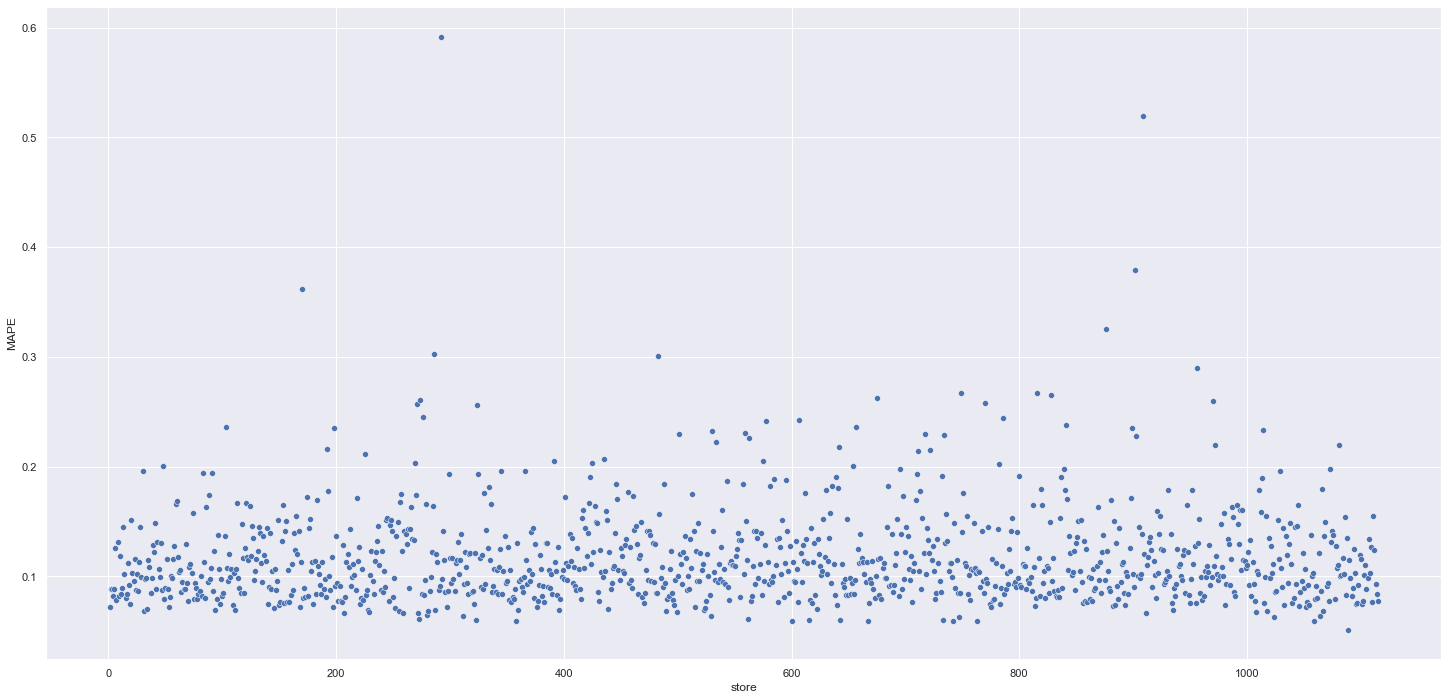

In [254]:
sns.scatterplot(x='store',y='MAPE', data=df92)

Podemos ver que algumas lojas tem um erro bem grande, algo em torno de 50%. A maioria se encontra com um erro de até 10%.

## <p style="color:#FF0000">9.2 Total Performance</p>

In [255]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 286,675,456.00"
1,worst_scenario,"R$ 285,809,942.91"
2,best_scenario,"R$ 287,540,984.78"


Então, temos o melhor e o pior cenário, além das predições.

## <p style="color:#FF0000">9.3. Machine Learning Performance</p>

In [256]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

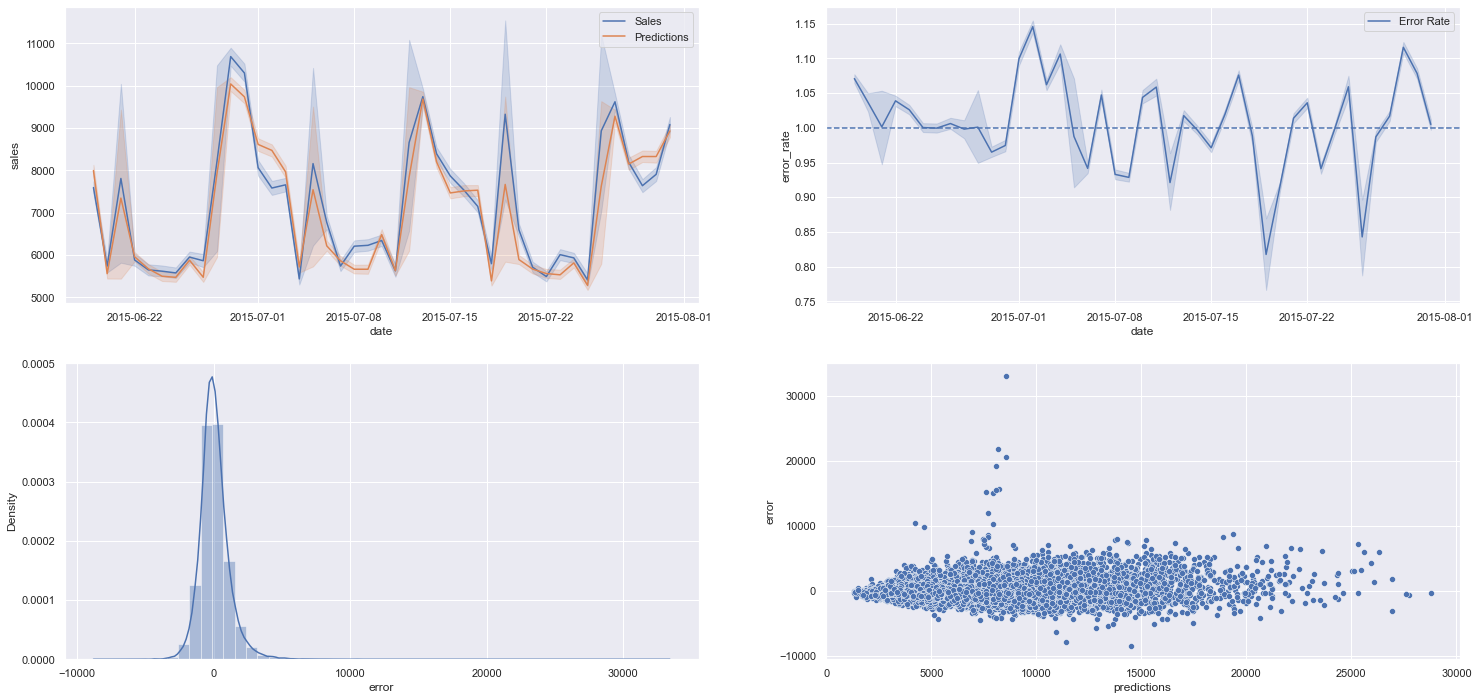

In [257]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='Sales')
sns.lineplot(x='date',y='predictions',data=df9,label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9,label='Error Rate')
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

Em (1,1) é possível ver que as predições das lojas estão bem próximas do resultado de teste ao longo do tempo, o que é um indicativo de que o modelo performou bem.

Em (1,2) é a porcentagem das previsões em relação a venda, a error_rate. Acima da linha 1, o modelo superestiou o resultado, abaixo ele subestimou.

Em (2,1) vê-se que o erro tem uma distribuição bem próxima de uma normal; isso é importante pois é um indicativo de que os erros estão próximos de 0.

Em (2,2) é possível ver que previsões entre valores de 5k e 10k têm os maiores erros. Em termos da análise de resíduo, o modelo está como um "tubo" na maioria dos pontos, o que, na teoria dos resíduos, é um indício de uma boa performance.

# <p style="color:#FF0000">10. Deploy Model to Production</p>

A ideia do deploy é que qualquer pessoa possa acessar o seu modelo. Seja por uma API, Google Sheets, Excel, etc. Aqui será por API e por um bot no telegram.

## <p style="color:#FF0000">10.1. Rossmann Class</p>

In [258]:
pickle.dump(model_xgb_tunned, open('/Users/ASPIREB E15/Downloads/Data Science/Rosmann Store Sales Prediction/model/model_rossmann.pkl', 'wb'))

In [259]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/ASPIREB E15/Downloads/Data Science/Rosmann Store Sales Prediction/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## <p style="color:#FF0000">10.2. API Handler</p>

In [260]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/ASPIREB E15/Downloads/Data Science/Rosmann Store Sales Prediction/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## <p style="color:#FF0000">10.3. API Tester</p>

In [261]:
import requests
import pandas as pd

In [262]:
# loading test dataset
df10 = pd.read_csv( 'C:/Users/ASPIREB E15/Downloads/Data Science/Rosmann Store Sales Prediction/data/test.csv' )

In [263]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [264]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [265]:
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [271]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [272]:
# API Call
#url = 'http://10.0.0.171:5000/rossmann/predict'
url = ' https://rossmann-model-caio.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [289]:
data[0:357]

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}'

In [290]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [291]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,20,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,8012.485840
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6069.162109
2,23,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4060.0,8,2005,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,6525.627441
3,20,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,basic,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2009-05-01T00:00:00.000Z,77,2014-09-29T00:00:00.000Z,50,7942.749512
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6063.706055


In [292]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$ 287,114.19 in the next 6 weeks
Store Number 22 will sell R$ 216,786.78 in the next 6 weeks
Store Number 23 will sell R$ 224,332.79 in the next 6 weeks


URL para acessar a API: https://rossmann-model-caio.herokuapp.com/rossmann/predict

Para acessar via telegram: https://t.me/rossmann_caio_bot